In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from scipy.stats import describe, kstest, mannwhitneyu, sem
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 14})

In [3]:
"""Set torch device."""

device = t.device("cpu")  # small toy models may be faster via cpu
# device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
# print(f"{device_name=}")

## *relu*

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$ 

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [4]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    # x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    x = t.randint(-1, 2, (batch_sz, model.cfg.n_instances, model.cfg.n_feat), device=device).float()  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

#### n_feat=2, n_hidden=1

---

---

##### compare o3 analytical weights (and loss) solution to trained weights and loss

For each sparsity level for `n_runs`, eval model and store loss and weights

In [5]:
# Set some constants

n_runs = 5
batch_sz = 64
feat_importance = 1
x_factor = 5000

feat_sparsity_train = np.array((0.01, 0.1, 0.5, 0.9, 0.99))
feat_sparsity_eval = feat_sparsity_train
feat_prob_train = 1 - feat_sparsity_train
feat_prob_eval = 1 - feat_sparsity_eval

In [6]:
# Spec model

layer_act_fns = [t.relu, lambda x: x]
simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

In [ ]:
# Train

dtype = t.float32
all_losses_adj = defaultdict(lambda: defaultdict(list))
all_weights = defaultdict(lambda: defaultdict(list))
n_steps = np.array((1 / feat_prob_train * x_factor)).astype(int)
pbar = tqdm(
    zip(feat_sparsity_train, n_steps), 
    desc="Testing over sparsities", 
    total=len(feat_sparsity_train)
)

# Loop over sparsities for training
for s_t, n in pbar:

    p_t = np.round(1 - s_t.item(), 2)

    # Set analytically optimal weights
    W1_1 = np.sqrt(
        ( ( p_t + 2 * (1 - p_t) ) + np.sqrt( (p_t ** 2) + 4 * (1 - p_t) ** 2 ) )
        / (4 * p_t)
    )
    W1_2 = np.sqrt(
        ( ( p_t + 2 * (1 - p_t) ) - np.sqrt( (p_t ** 2) + 4 * (1 - p_t) ** 2 ) )
        / (4 * p_t)
    )
    W2_1 = W1_1 / (W1_1**2 + W1_2**2)
    W2_2 = (
        ( ( p_t * (W1_1 + W1_2) ) + ( 2 * (1 - p_t) * W1_2 ) )
        / ( 2 * (W1_1**2 + W1_2**2) )
    )
    relu_cis_a = Cis(simple_relu_cfg, device=device)
    W1 = t.tensor((W1_1, W1_2), dtype=dtype)
    W2 = t.tensor((W2_1, W2_2), dtype=dtype)
    W1 = W1.unsqueeze(0).unsqueeze(0)
    W2 = W2.unsqueeze(0).unsqueeze(0)
    relu_cis_a.W1.data = W1
    relu_cis_a.W2.data = W2

    # Store weights
    p_t = str(p_t)
    all_weights[p_t]["W1"].append(asnumpy(relu_cis_a.W1))
    all_weights[p_t]["W2"].append(asnumpy(relu_cis_a.W2))

    # print(f"{p_t=}")
    # print(f"{W1=}")
    # print(f"{W2=}")
    # print()

    pbar2 = tqdm(range(n_runs), desc="Training feature prob")
    for run in pbar2:

        relu_cis = Cis(simple_relu_cfg, device=device)
        optimizer = t.optim.Adam(relu_cis.parameters(), lr=1e-3)

        logging_freq = n // 5

        _ = train(
            relu_cis,
            batch_sz,
            s_t,
            feat_importance,
            loss_fn,
            optimizer,
            n,
            logging_freq,
            device
        )

        # Store trained weights
        all_weights[p_t]["W1"].append(asnumpy(relu_cis.W1))
        all_weights[p_t]["W2"].append(asnumpy(relu_cis.W2))

        for s_e in feat_sparsity_eval:

            p_e = np.round(1 - s_e.item(), 2)
            
            if run == 0:  # only do analytical weights for first run
                # Analytically optimal weights eval
                eval_loss_a = eval_model(
                    relu_cis_a, 
                    batch_sz=100000, 
                    feat_sparsity=s_e,
                    n_batches=100,
                    device=device
                ).mean().item()
                all_losses_adj[p_t][p_e].append(eval_loss_a / float(p_e))  # store eval loss
            
            eval_loss = eval_model(
                relu_cis, 
                batch_sz=100000, 
                feat_sparsity=s_e,
                n_batches=100,
                device=device
            ).mean().item()

            all_losses_adj[p_t][p_e].append(eval_loss / float(p_e))  # store eval loss
        
        # Print some info
        # print(f"Trained at p = {p_t}:\n")
        # print(f"{relu_cis.W1=}")
        # print(f"{relu_cis.W2=}\n")
        # print(f"losses: {all_losses_adj[p_t]}")
        # print(f"-----\n\n")

Testing over sparsities:   0%|          | 0/5 [00:00<?, ?it/s]

Training feature prob:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5050 [00:00<?, ?it/s]

Training:   0%|          | 0/5050 [00:00<?, ?it/s]

Training:   0%|          | 0/5050 [00:00<?, ?it/s]

Training:   0%|          | 0/5050 [00:00<?, ?it/s]

Training:   0%|          | 0/5050 [00:00<?, ?it/s]

Training feature prob:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5555 [00:00<?, ?it/s]

Training:   0%|          | 0/5555 [00:00<?, ?it/s]

Training:   0%|          | 0/5555 [00:00<?, ?it/s]

Training:   0%|          | 0/5555 [00:00<?, ?it/s]

Training:   0%|          | 0/5555 [00:00<?, ?it/s]

Training feature prob:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training feature prob:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training feature prob:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/499999 [00:00<?, ?it/s]

Training:   0%|          | 0/499999 [00:00<?, ?it/s]

Training:   0%|          | 0/499999 [00:00<?, ?it/s]

Training:   0%|          | 0/499999 [00:00<?, ?it/s]

Training:   0%|          | 0/499999 [00:00<?, ?it/s]

In [11]:
all_losses_adj

defaultdict(<function __main__.<lambda>()>,
            {'0.99': defaultdict(list,
                         {'0.99': [0.40928411363351225, 0.13758773454512008],
                          '0.90': [0.4228521055645413, 0.14089379045698378],
                          '0.50': [0.48430195450782776, 0.15559007227420807],
                          '0.10': [0.5448168143630028, 0.17002113163471222],
                          '0.01': [0.5588680971413851,
                           0.1727658906020224,
                           13.589239120483398,
                           12.667933106422424,
                           7.783046364784241,
                           1.705886423587799,
                           0.17474660417065024,
                           13.589859008789062,
                           12.660075724124908,
                           7.791206985712051,
                           1.7106449231505394,
                           0.1733292592689395,
                           13.5988697

---

---

##### train model at different sparsisites for n_runs, and evaluate each training run on a set of evaluation sparsities

In [ ]:
feat_sparsity_train = np.array((0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99))
x_factor = 5000
#feat_sparsity_eval = np.array((0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99))
feat_sparsity_eval = feat_sparsity_train
feat_prob_train = 1 - feat_sparsity_train
feat_prob_eval = 1 - feat_sparsity_eval
naive_loss_adj = 1/6 * 1/2
naive_losses = 1/6 * 1/2 * (1 - feat_sparsity_eval)
# estimated number of steps to reach naive loss
n_steps = np.array( (1 / (1 - feat_sparsity_train) * x_factor).astype(int) )

print(f"{n_steps=}")

n_steps=array([  5050,   5555,   6250,   8333,  12500,  25000,  50000, 499999])


In [6]:
"""Spec model."""

layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)


In [ ]:
"""Train model."""

n_runs = 5  # training runs per sparsity
batch_sz = 64
feat_importance = 1
losses_adj = defaultdict(lambda: defaultdict(list))

pbar = tqdm(
    zip(feat_sparsity_train, n_steps), 
    desc="Testing over sparsities", 
    total=len(feat_sparsity_train)
)
for s_t, n in pbar:

    p_t = f"{1 - s_t.item():.2f}"
    
    pbar2 = tqdm(range(n_runs), desc=f"Training runs for feature prob {p_t}")
    for run in pbar2:

        relu_cis = Cis(simple_relu_cfg, device=device)
        optimizer = t.optim.Adam(relu_cis.parameters(), lr=1e-3)

        logging_freq = n // 10

        _ = train(
            relu_cis,
            batch_sz,
            s_t,
            feat_importance,
            loss_fn,
            optimizer,
            n,
            logging_freq,
            device
        )
        
        for s_e in feat_sparsity_eval:
            
            p_e = f"{1 - s_e.item():.2f}"
            
            eval_loss = eval_model(
                relu_cis, 
                batch_sz=100000, 
                feat_sparsity=s_e,
                n_batches=100,
                device=device
            ).mean().item()
            
            losses_adj[p_t][p_e].append(eval_loss / float(p_e))
        
        # Print some info
        print(f"Trained at p = {p_t}:\n")
        print(f"{relu_cis.W1=}")
        print(f"{relu_cis.W2=}\n")
        print(f"losses: {losses_adj[p_t]}")
        print(f"-----\n\n")


In [8]:
losses_adj

defaultdict(<function __main__.<lambda>()>,
            {'0.99': defaultdict(list,
                         {'0.99': [0.06767871855485319,
                           0.0677388801117136,
                           0.06774501367048784,
                           0.06769320579490276,
                           0.06769185866972413],
                          '0.90': [0.06951497660742866,
                           0.06956547498703003,
                           0.06954296595520443,
                           0.06958242091867659,
                           0.06963830027315351],
                          '0.80': [0.07155411876738071,
                           0.07160688750445843,
                           0.07170243188738823,
                           0.07167726755142212,
                           0.07164650596678257],
                          '0.60': [0.07557956501841545,
                           0.07567554091413817,
                           0.07595079640547435,
                   

C:\Users\jai\AppData\Local\Temp\ipykernel_49616\435617059.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


(0.065, 0.09)

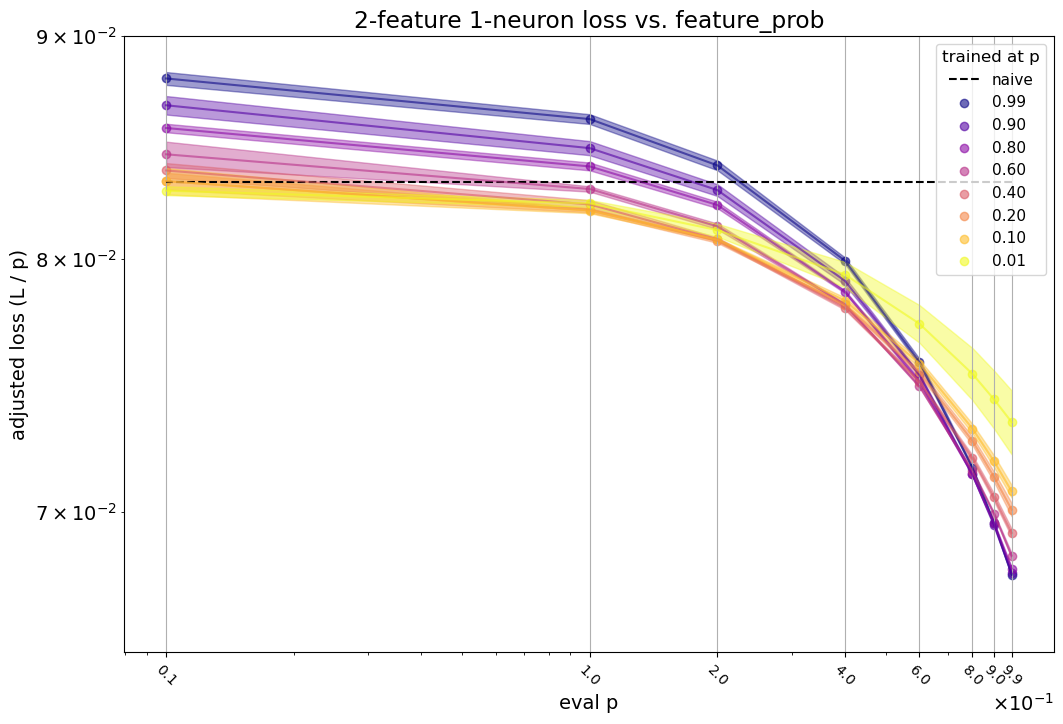

In [32]:
# Set colors for plotting
cmap_name = "plasma"
cmap = plt.cm.get_cmap(cmap_name)
colors = [cmap(i) for i in np.linspace(0, 1, len(feat_sparsity_train))]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

not_learned_thresh = 0.12  # threshold for loss, above which we assume training run failed

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# naive loss line
ax.plot(
    feat_prob_eval,
    naive_loss_adj * np.ones_like(feat_prob_eval),
    label="naive", 
    color="black", 
    linestyle="--"
)

for i, train_p in enumerate(losses_adj.keys()):

    means = []
    std_errs = []
    eval_ps = losses_adj[train_p]
    
    for eval_p in eval_ps.keys():
        cur_adj_loss = np.array(losses_adj[train_p][eval_p])
        # Remove "outlier" runs that failed to learn
        cur_adj_loss = cur_adj_loss[cur_adj_loss < not_learned_thresh]
        means.append(np.mean(cur_adj_loss))
        std_errs.append(sem(cur_adj_loss))
    
    # Plot means (scatter and line plot) and std errs with fill
    means = np.array(means)
    std_errs = np.array(std_errs)

    ax.scatter(
        feat_prob_eval, 
        means, 
        label=f"{train_p}",
        color=colors[i],
        alpha=0.6
    )
    ax.plot(
        feat_prob_eval, 
        means, 
        color=colors[i], 
        alpha=0.6
    )
    ax.fill_between(
        feat_prob_eval, 
        means - 2 * std_errs,
        means + 2 * std_errs,
        color=colors[i],
        alpha=0.4,
    )

ax.legend(loc="upper right", fontsize=11, title="trained at p", title_fontsize=12)
ax.grid()
ax.set_xlabel("eval p")
ax.set_ylabel("adjusted loss (L / p)")
ax.set_title("2-feature 1-neuron loss vs. feature_prob")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(feat_prob_eval)
ax.set_xticklabels(np.round(feat_prob_eval, 2), rotation=-45, fontsize=10)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax.set_ylim(6.5e-2, 9e-2)
# ax.set_xlim(6e-1, 10e-1)

---

---

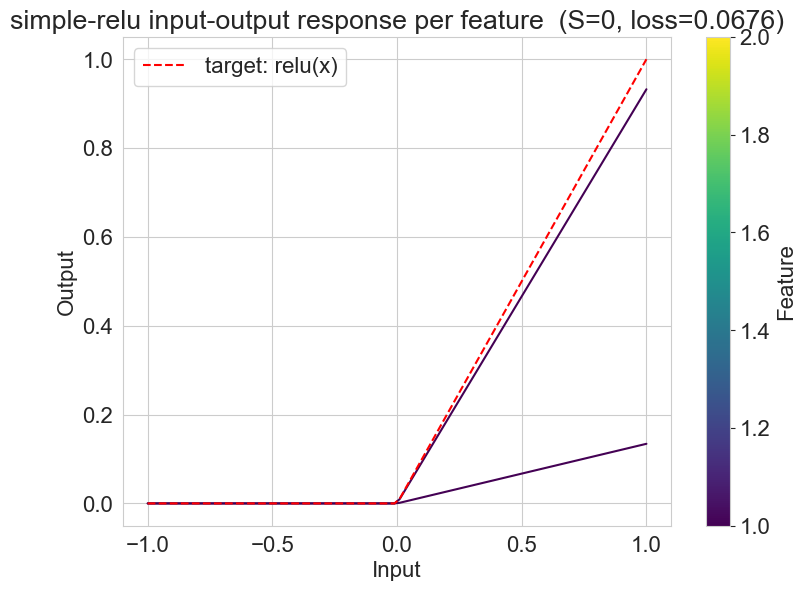

In [21]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu input-output response per feature  (S={feat_sparsity}, loss={losses[-1]:.4f})")
ax.legend()

W.shape=torch.Size([1, 2])


Text(0.5, 1.0, 'simple-relu feature weights per neuron')

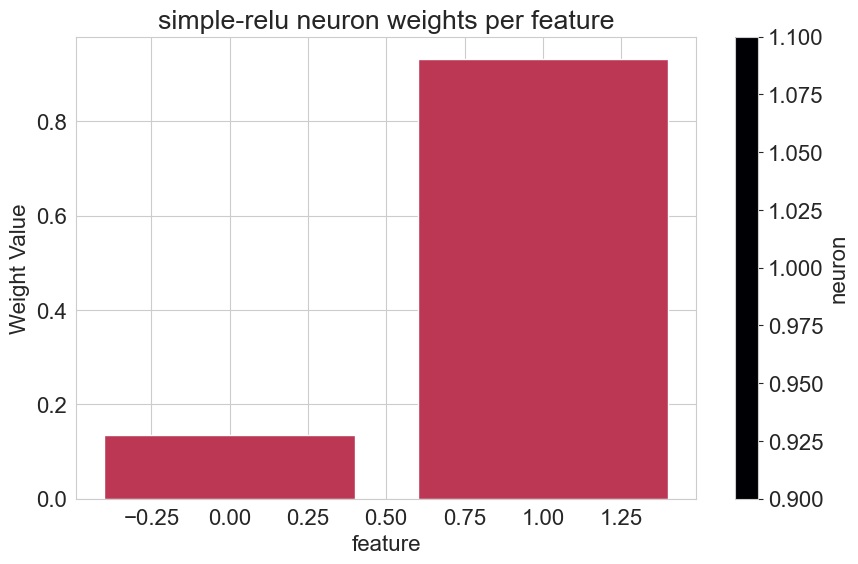

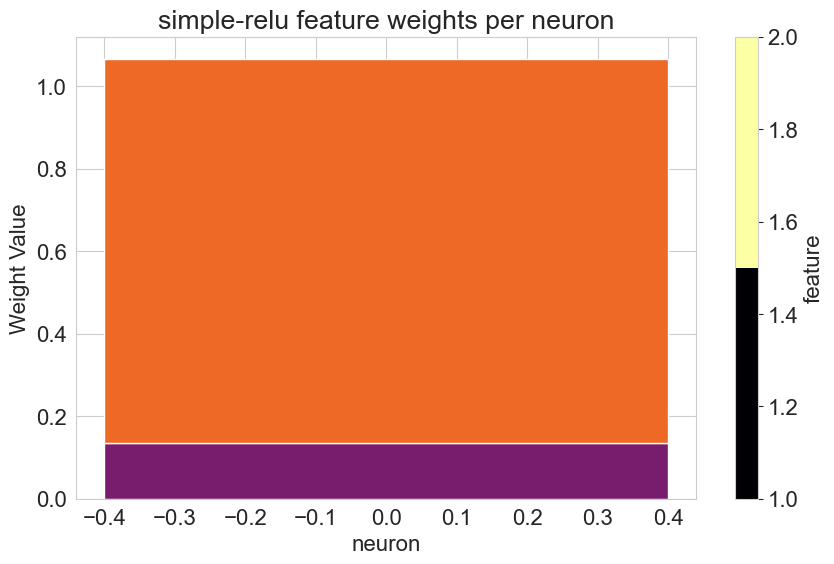

In [22]:
W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("simple-relu neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("simple-relu feature weights per neuron")

#### n_feat=100, n_hidden=50

In [69]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
)

relu_cis = Cis(simple_relu_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq,
    device
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.001721310312859714,
 0.0009864099556580186,
 0.0009828703477978706,
 0.0007618971285410225,
 0.0009833661606535316,
 0.000984956743195653,
 0.0007486212998628616,
 0.001026565209031105,
 0.001065376796759665,
 0.000962790276389569,
 0.0008866098360158503]

### viz

#### input-output response

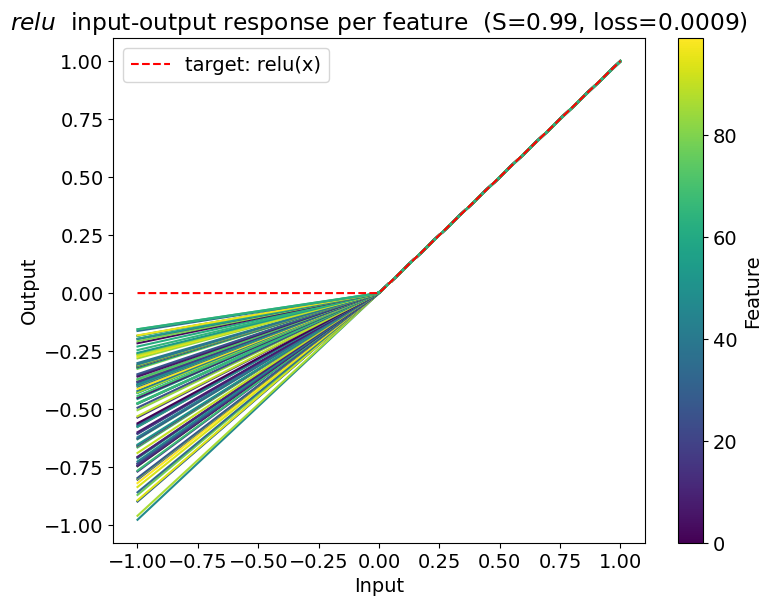

In [70]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals) + vals, "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(
    r"$\mathit{relu}$  " 
    + f"input-output response per feature  (S={feat_sparsity}, loss={losses[-1]:.4f})"
)
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{relu}$ feature weights per neuron')

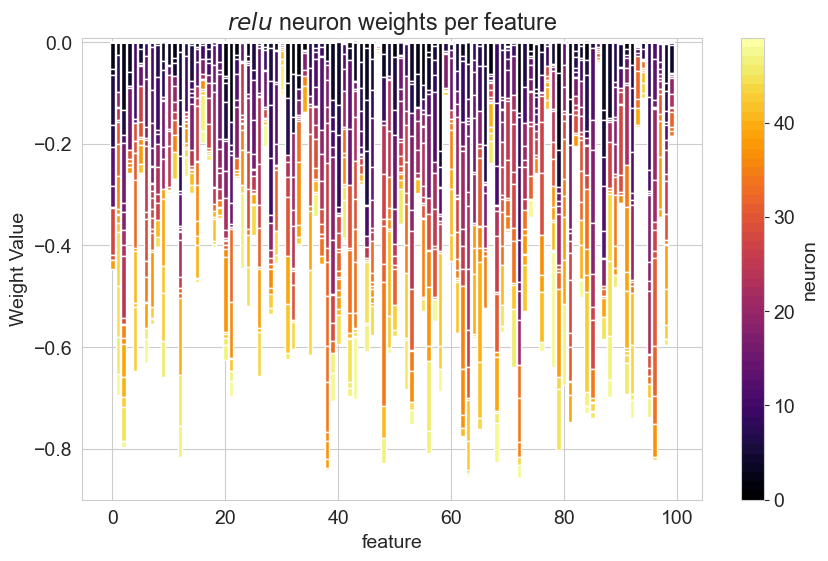

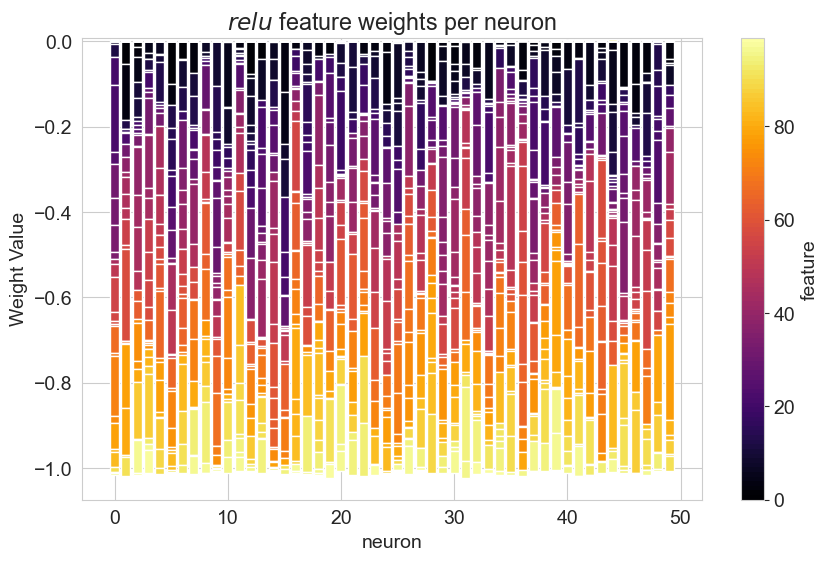

In [71]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title(r"$\mathit{relu}$ neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title(r"$\mathit{relu}$ feature weights per neuron")

Text(0.5, 1.0, 'Distribution of nonzero neuron weights per feature')

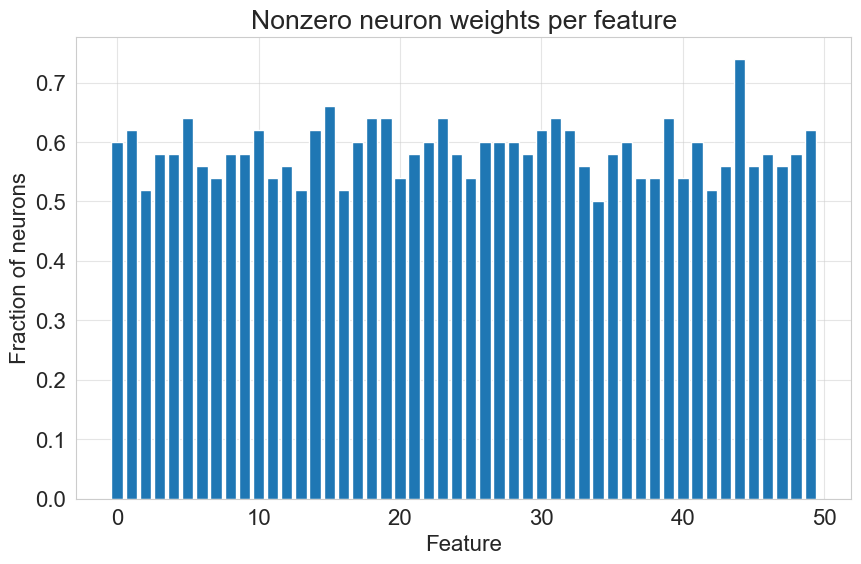

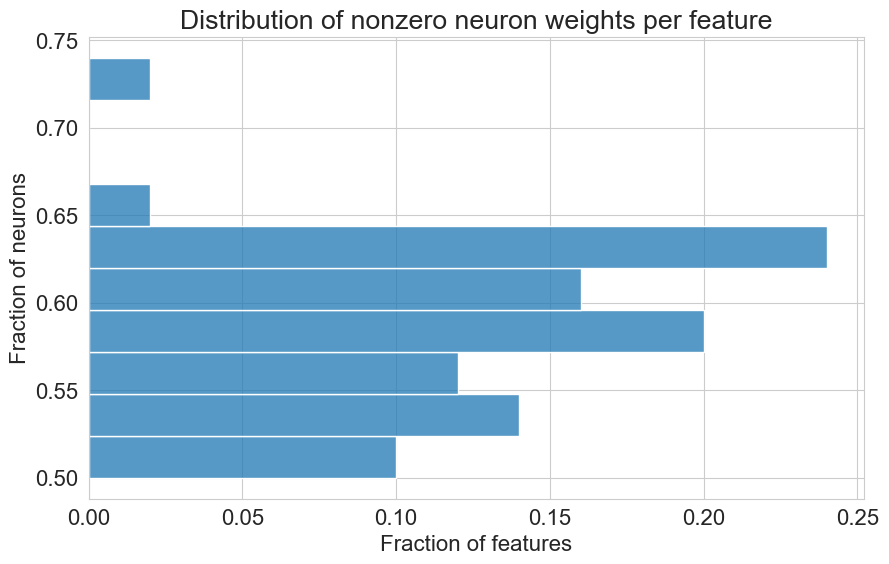

In [26]:
"""Plot nonzero neuron weights per feature."""

nonzero_counts = reduce(W, "neuron feature -> neuron", t.count_nonzero)
frac_nonzero = nonzero_counts / relu_cis.cfg.n_hidden
frac_nonzero = asnumpy(frac_nonzero)

# Plot nonzero_counts per feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(nonzero_counts)), frac_nonzero)
ax.set_xlabel("Feature")
ax.set_ylabel("Fraction of neurons")
ax.set_title("Nonzero neuron weights per feature")
ax.grid(True, alpha=0.5)

# Plot distribution of nonzero_counts
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=pd.DataFrame({"frac_nonzero": frac_nonzero}),
    y="frac_nonzero",
    binwidth=0.025,
    stat="probability",
    ax=ax
)
ax.set_xlabel("Fraction of features")
ax.set_ylabel("Fraction of neurons")
ax.set_title("Distribution of nonzero neuron weights per feature")

#### how many features are learned? or, what is loss per feature?

Text(0.5, 1.0, 'Loss per feature, for 1000 examples per feature')

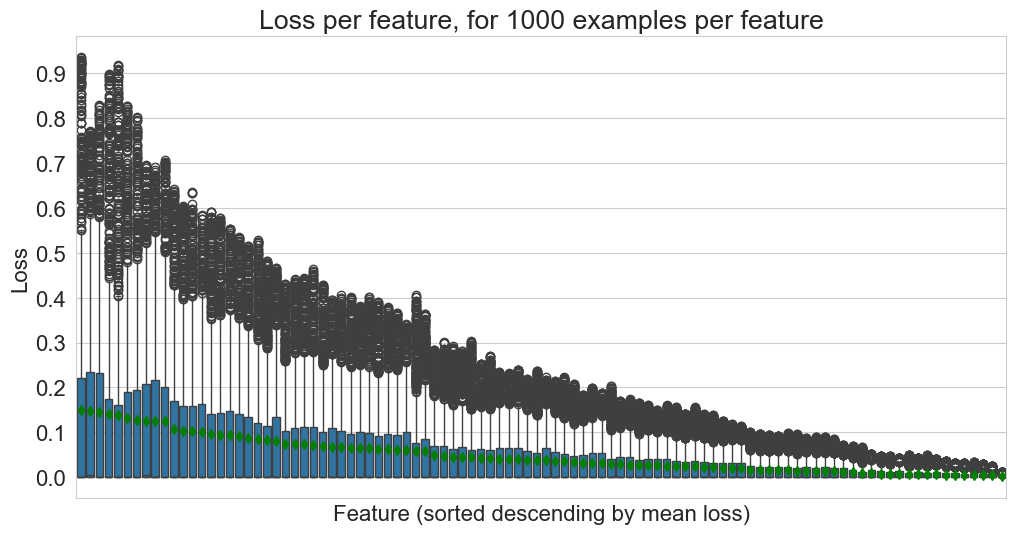

In [32]:
"""Box of loss per feature, ranked from highest mean loss to lowest."""

n_examples = 1000
losses = t.zeros((n_examples, relu_cis.cfg.n_feat), device=device)

# Activate only one feature at a time and calculate loss for that feature; loop for all features
for feat in range(relu_cis.cfg.n_feat):
    x = t.zeros(
        n_examples, relu_cis.cfg.n_instances, relu_cis.cfg.n_feat, device=device
    )
    # make only feat-th feature active
    x[:, :, feat] = rearrange((t.rand(n_examples) * 2 - 1), "n -> n 1")
    y_true = t.relu(x)
    y = relu_cis.forward(x)
    losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()

sorted_idxs = t.argsort(reduce(losses, "example feat -> feat", "mean"), descending=True)
losses = losses[:, sorted_idxs]
sorted_idxs = asnumpy(sorted_idxs)
df = pd.DataFrame(asnumpy(losses))
df_melted = df.melt(var_name="Feature", value_name="Loss")

fig, ax = plt.subplots(figsize=(12, 6))
meanprops = dict(marker="d", markerfacecolor="green", markeredgecolor="green", markersize=5)
sns.boxplot(data=df_melted, x="Feature", y="Loss", ax=ax, showmeans=True, meanprops=meanprops)

ax.set_xticks([], [])  # Hide x-axis labels if too many
ax.set_xlabel("Feature (sorted descending by mean loss)")
ax.set_ylabel("Loss")
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_title(f"Loss per feature, for {n_examples} examples per feature")

Text(0.5, 1.0, 'Distribution of mean loss per feature')

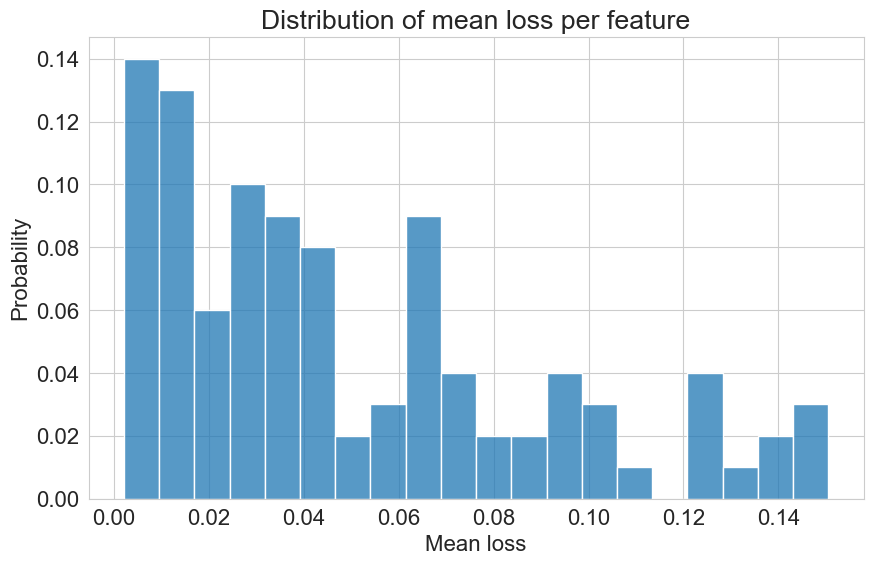

In [33]:
"""Distribution of mean loss per feature."""

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    asnumpy(reduce(losses, "example feat -> feat", "mean")), bins=20, stat="probability", ax=ax
)
ax.set_xlabel("Mean loss")
ax.set_title("Distribution of mean loss per feature")

#### loss and polysemanticity as a function of sparsity

1. polysemanticity (distribution of nonzero weights per feature)
  
2. distribution of loss per feature

In [40]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_cis = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_cis.parameters())
    losses = train(
        relu_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / relu_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(relu_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, relu_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(relu_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                relu_cis.cfg.n_instances, 
                relu_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = relu_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

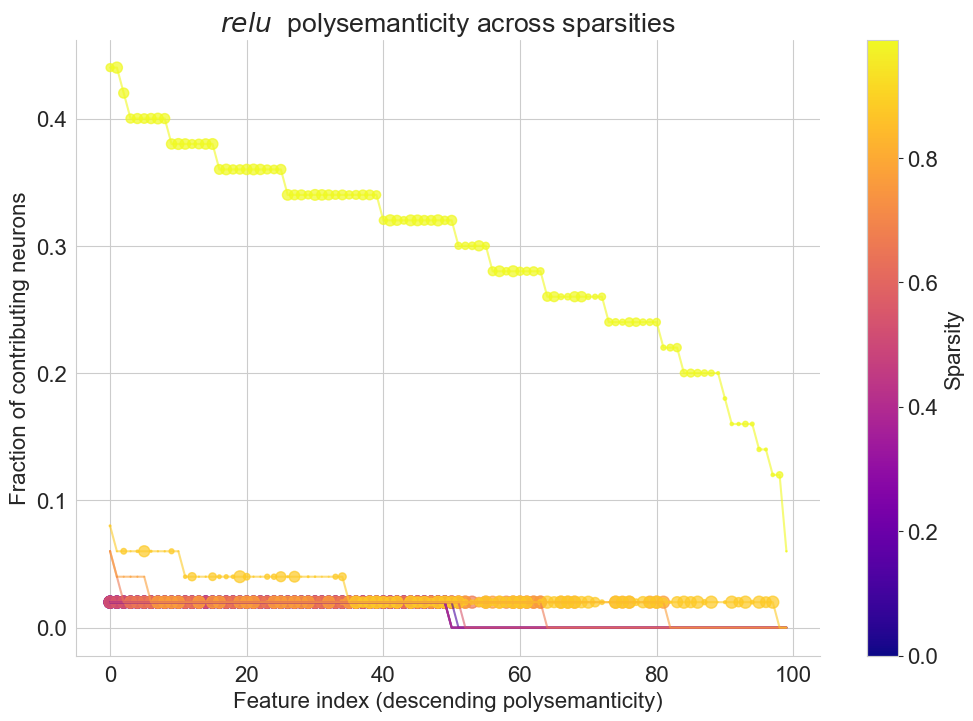

In [42]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{relu}$  polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

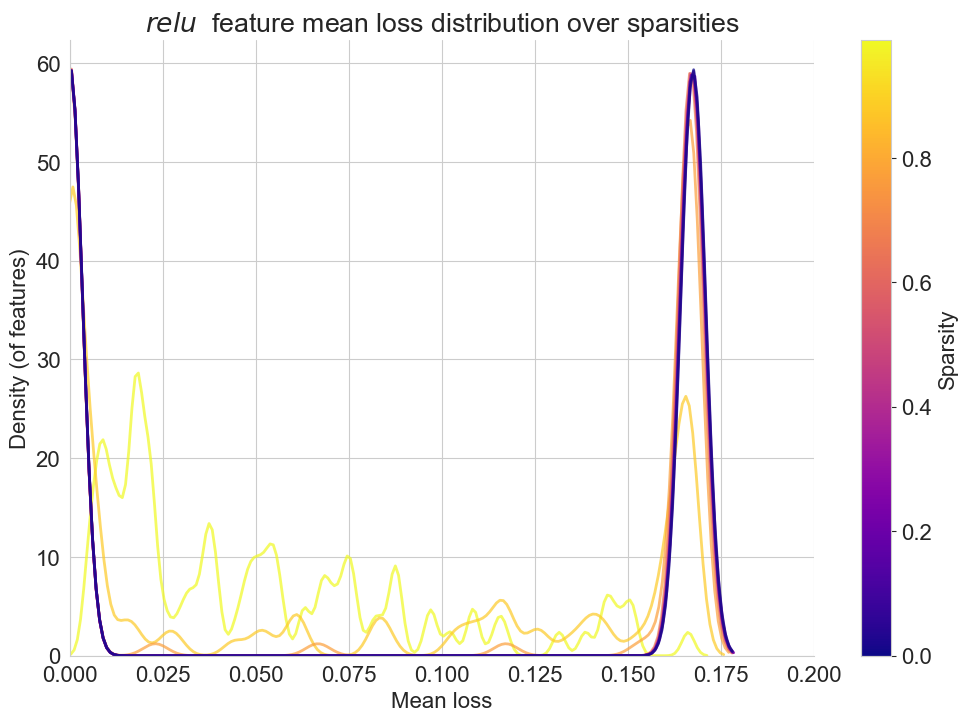

In [44]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{relu}$  feature mean loss distribution over sparsities")
ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

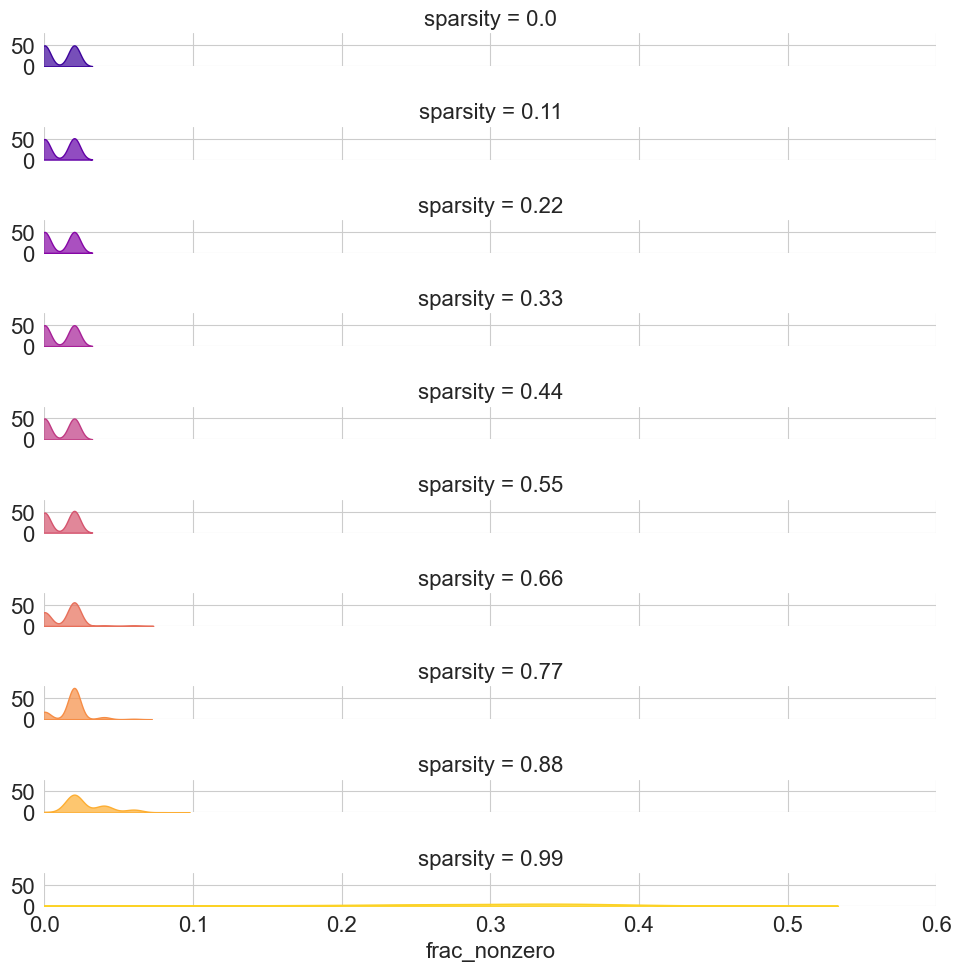

In [46]:
"""Could also potentially plot polysemanticity (and loss) per sparsity level as facetgrid
where each sparsity level has its own axis - but this doesn't look as good imo
"""

g = sns.FacetGrid(
    df_poly,
    row="sparsity",
    hue="sparsity",
    aspect=10,  # wide aspect so we can see the ridgeline shape
    height=1,  # each subplot’s height in inches
    palette="plasma",   
    sharex=True,        
    sharey=True
)

g.map(
    sns.kdeplot,
    "frac_nonzero",
    fill=True,
    alpha=0.7, 
)
g.set(ylabel=None)
g.set(xlim=(0, 0.6))
g.despine(left=True, bottom=True)


## *relu_onehot*

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (one-hot vector):

$$
x = \text{randint}(-1, 1) \\
$$ 

Loss (weighted mse):

$$
\text{WMSE} = \frac{1}{N} \sum_{i=1}^{N} w_i \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
\text{where} \\[2ex]
w_i =
\begin{cases}
10, & \text{if } y_{\text{true},i} = 1, \\
1, & \text{otherwise}.
\end{cases}
$$



### training

In [47]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
    active_positions = t.randint(
            0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
    )
    active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
    
    # Create index tensors for vectorized assignment
    batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
    instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
    x[batch_idx, instance_idx, active_positions] = active_values
    
    return x, t.relu(x)

def loss_fn(y: Float[Tensor, "batch inst feat"], y_true: Float[Tensor, "batch inst feat"]) -> Float:
    active_weight, inactive_weight = 10, 1
    weights = t.where(y_true == 1, active_weight, inactive_weight)
    wmse = weights * (y - y_true) ** 2
    return reduce(wmse, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [53]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

relu_onehot_cis_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_onehot_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)


batch_sz = 256
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(relu_onehot_cis.parameters())

losses = train(
    relu_onehot_cis,
    batch_sz,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.04728975147008896,
 0.004628343507647514,
 0.004478469491004944,
 0.004647082649171352,
 0.004869034979492426,
 0.0041213249787688255,
 0.004657336976379156,
 0.004648929461836815,
 0.004512019455432892,
 0.0049339644610881805,
 0.004313179291784763]

### viz

#### input-output response

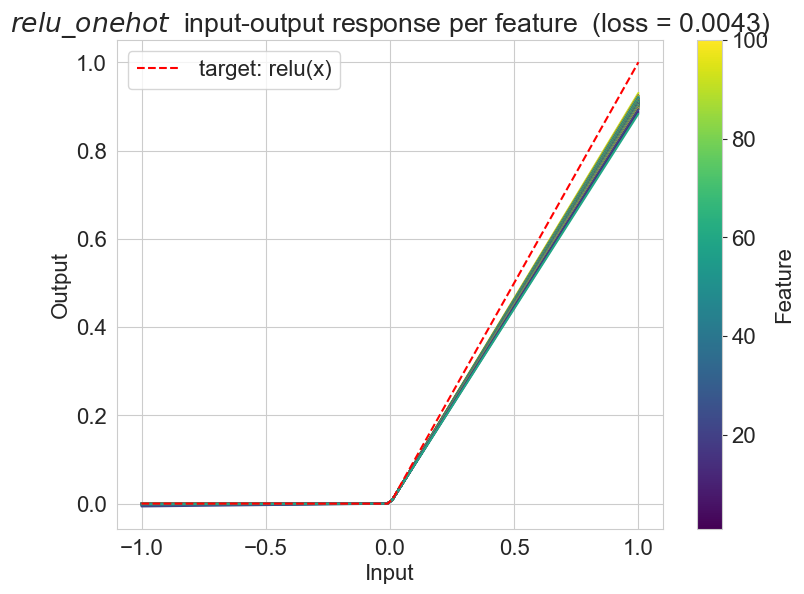

In [54]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_onehot_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(
    r"$\mathit{relu\_onehot}$  " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{relu\\_onehot}$  feature weights per neuron')

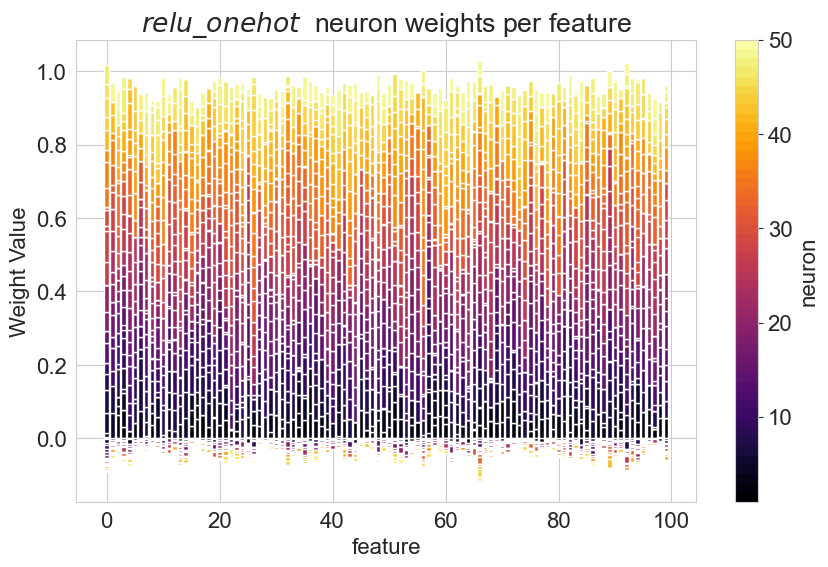

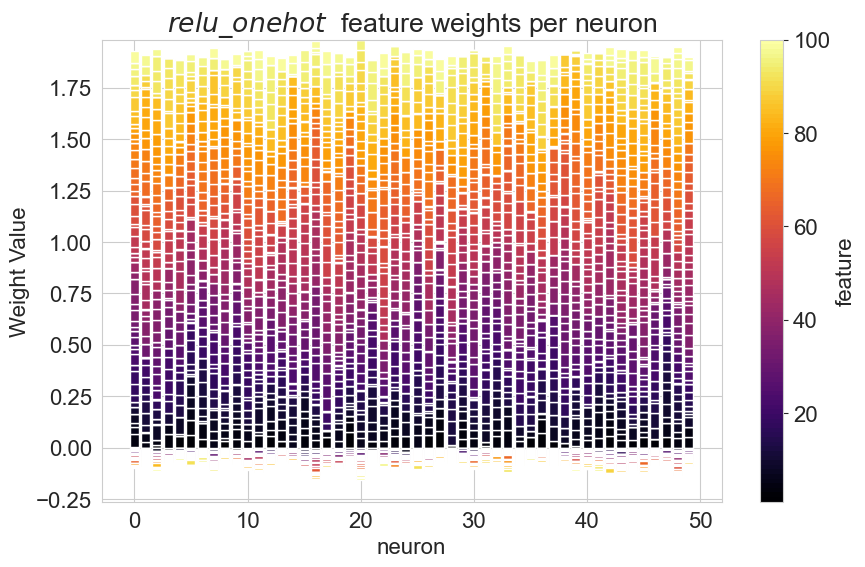

In [55]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_onehot_cis.W1, relu_onehot_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title( r"$\mathit{relu\_onehot}$  neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title( r"$\mathit{relu\_onehot}$  feature weights per neuron")

#### loss and polysemanticity as a function of sparsity

In [57]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_onehot_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_onehot_cis.parameters())
    losses = train(
        relu_onehot_cis,
        batch_sz,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        relu_onehot_cis.W1, relu_onehot_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / relu_onehot_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(relu_onehot_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, relu_onehot_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(relu_onehot_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                relu_onehot_cis.cfg.n_instances, 
                relu_onehot_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = relu_onehot_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

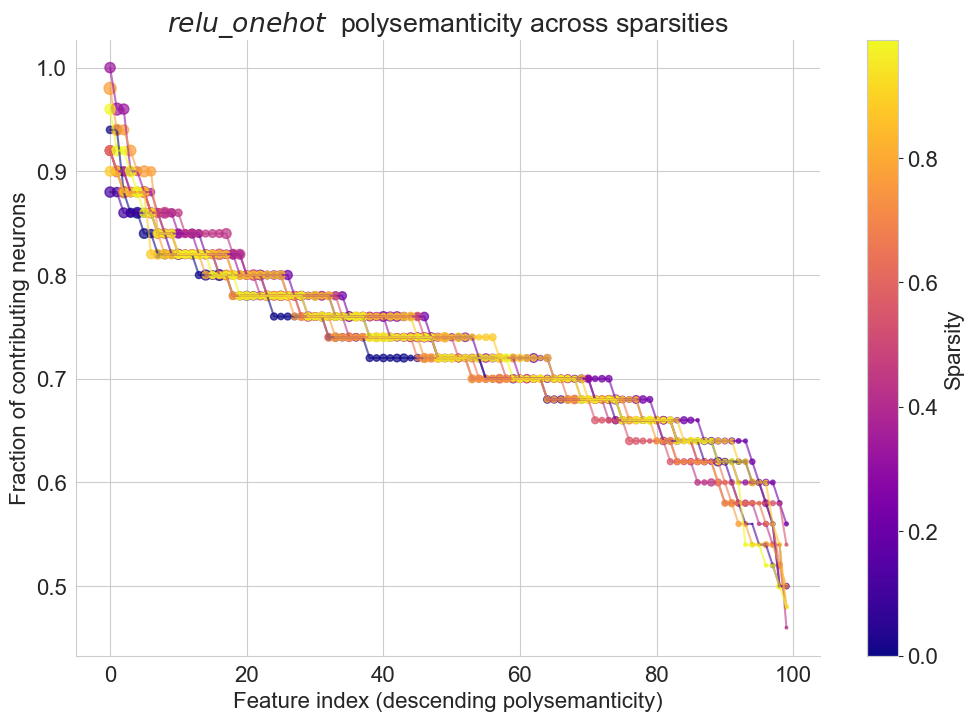

In [58]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{relu\_onehot}$  polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

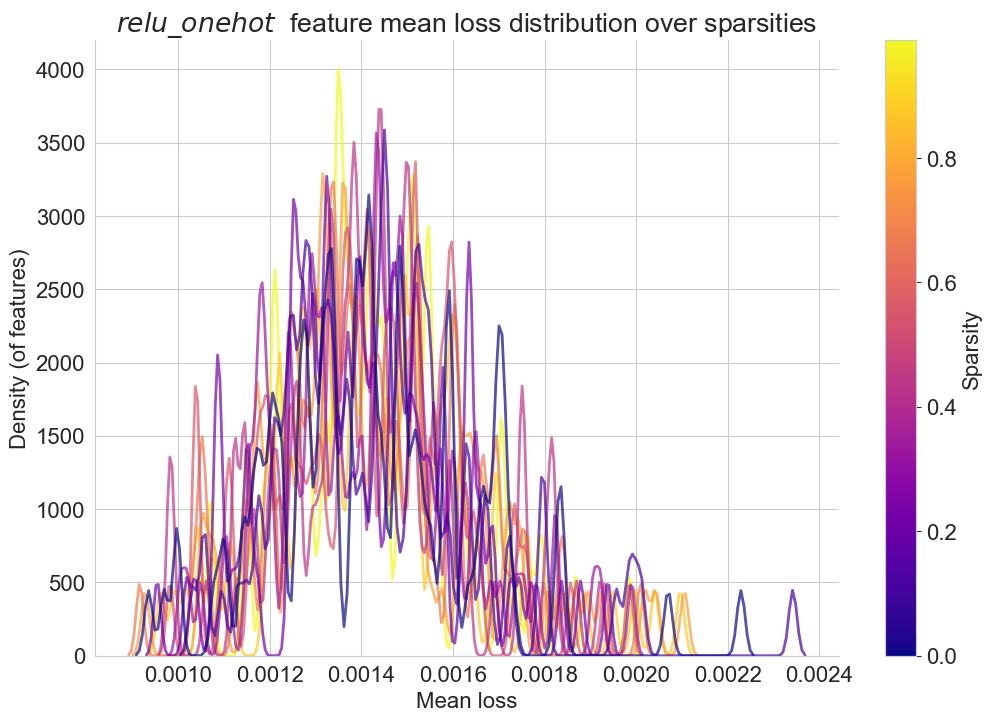

In [59]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{relu\_onehot}$  feature mean loss distribution over sparsities")
# ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

## *reluPlusX_res_noEmbed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [60]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [61]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())

losses = train(
    reluPlusX_res_noEmbed_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0018670830177143216,
 0.0008733125287108123,
 0.0011212435783818364,
 0.0012039793655276299,
 0.0008082141866907477,
 0.000859147752635181,
 0.0009426031028851867,
 0.0008009129669517279,
 0.0009581524063833058,
 0.0009997274028137326,
 0.0008524861186742783]

### viz

#### input-output response

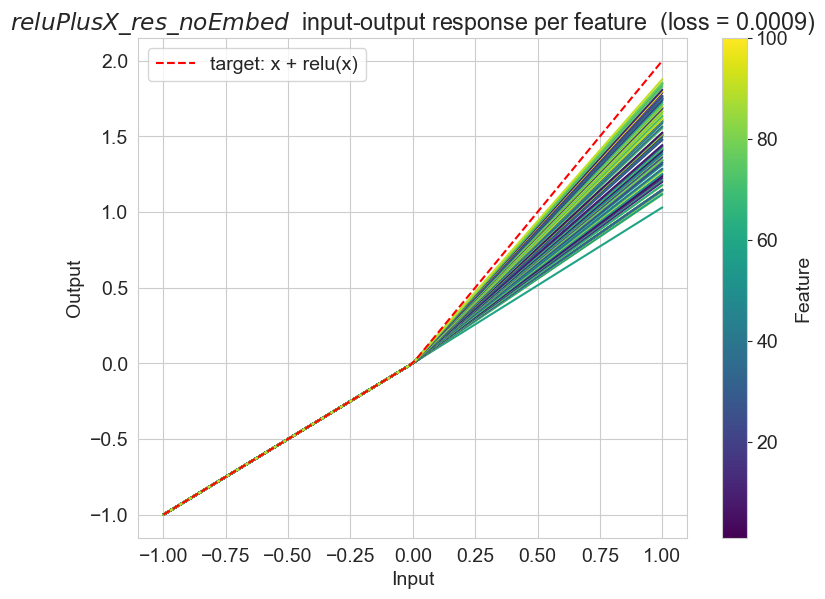

In [ ]:
"""Calculate and plot input-output response."""

plt.rcParams.update({"font.size": 14})

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_noEmbed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_noEmbed}$  " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{reluPlusX\\_res\\_noEmbed}$ feature weights per neuron')

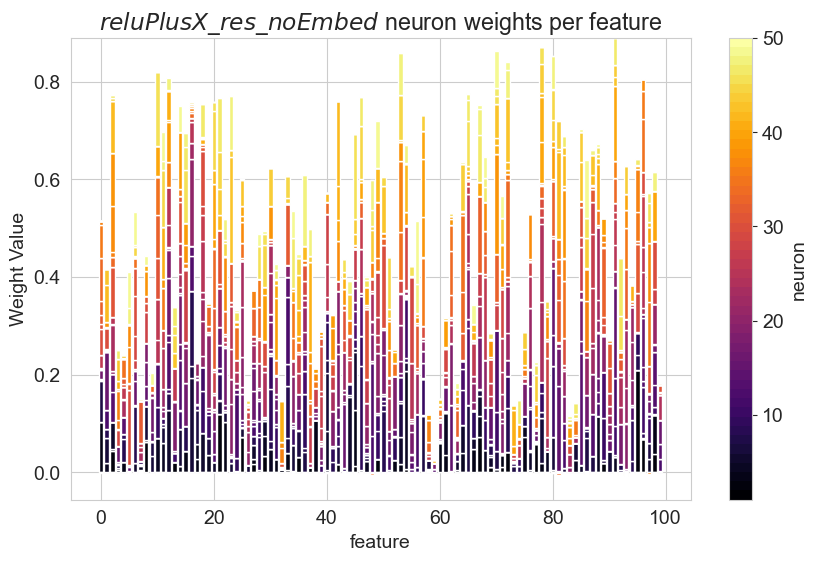

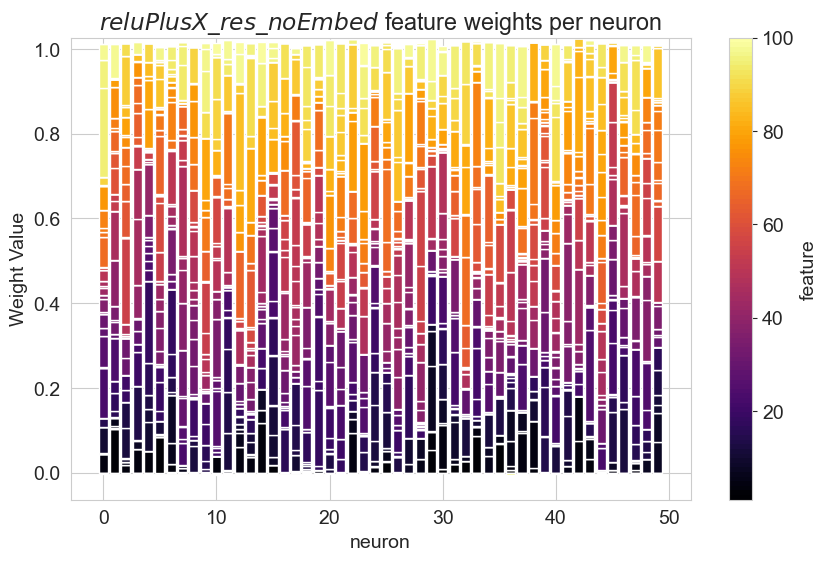

In [66]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_noEmbed_cis.W1, 
    reluPlusX_res_noEmbed_cis.W2, 
    "inst neuron feature, inst feature neuron-> neuron feature"
)
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$ neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$ feature weights per neuron")

#### loss and polysemanticity as a function of sparsity

In [71]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    reluPlusX_res_noEmbed_cis = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())
    losses = train(
        reluPlusX_res_noEmbed_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        reluPlusX_res_noEmbed_cis.W1,
        reluPlusX_res_noEmbed_cis.W2,
        "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / reluPlusX_res_noEmbed_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(reluPlusX_res_noEmbed_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, reluPlusX_res_noEmbed_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(reluPlusX_res_noEmbed_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                reluPlusX_res_noEmbed_cis.cfg.n_instances, 
                reluPlusX_res_noEmbed_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = reluPlusX_res_noEmbed_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

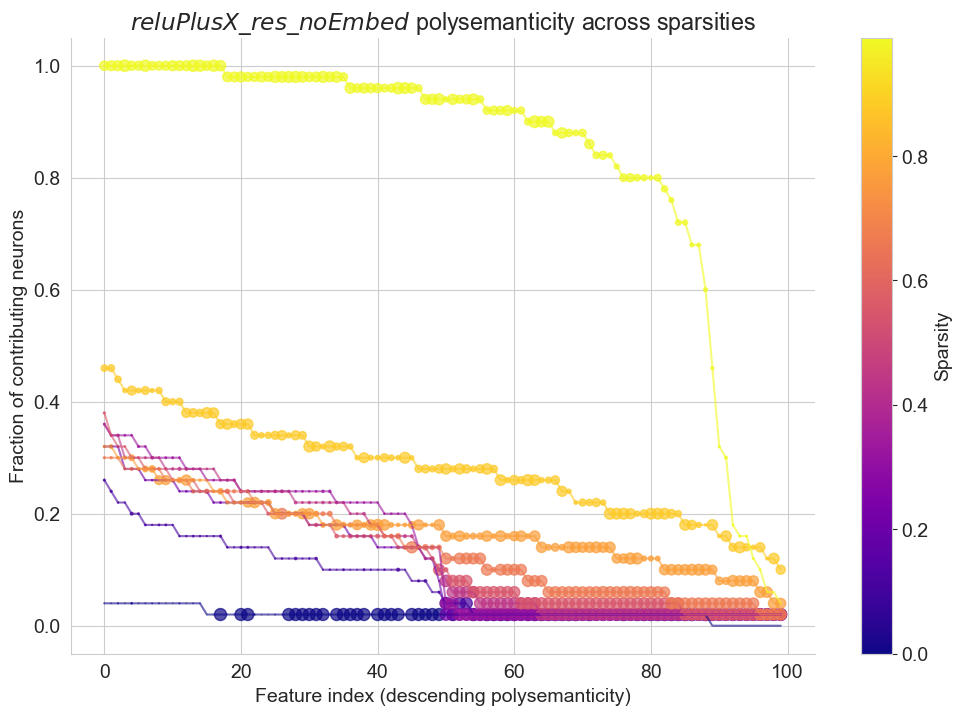

In [72]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$ polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

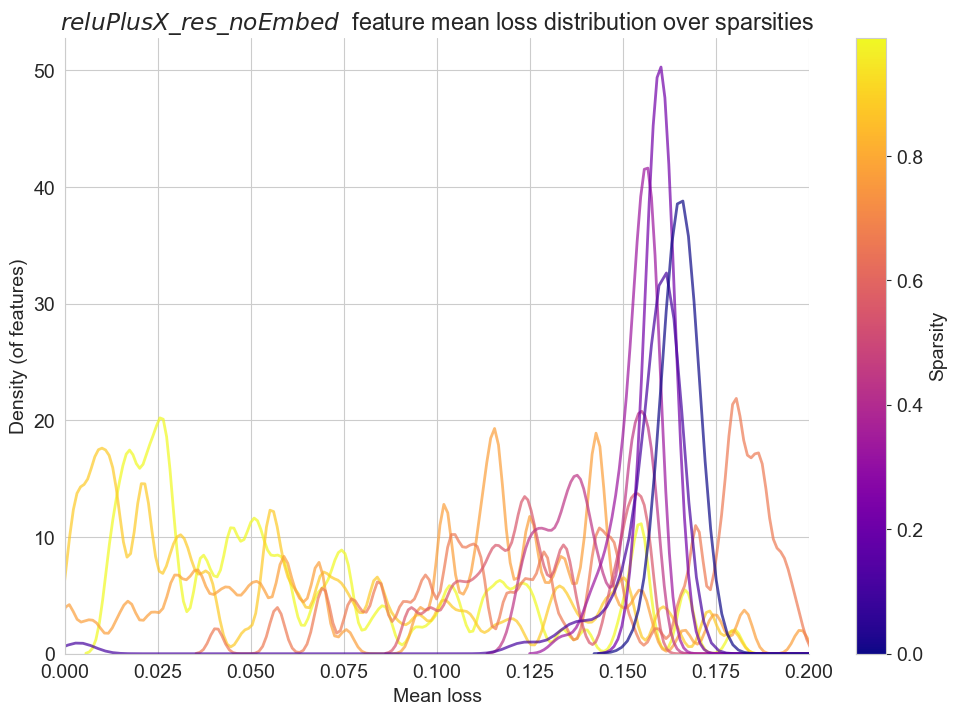

In [74]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$  feature mean loss distribution over sparsities")
ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

## *reluPlusX_res_embed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x \\
h = ReLU(W_1 e) \\
u = W_2 h + x
y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [105]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"], device: t.device) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x) + x

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

In [106]:
"""Create and train model."""

n_runs = 1
min_loss = []
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 5000
logging_freq = n_steps // 10

for run in range(n_runs):
    # Create model
    reluPlusX_res_embed_cfg = CisConfig(
        n_instances=1,
        n_feat=100,
        n_hidden=50,
        act_fn=layer_act_fns,
        b1=None,
        b2=None,
        skip_cnx=True,
        We_and_Wu=True,
        We_dim=1000
    )
    reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)

    # Train model
    optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

    losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq,
        device
    )
    min_loss.append(min(losses))

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

(-0.2, 0.2)

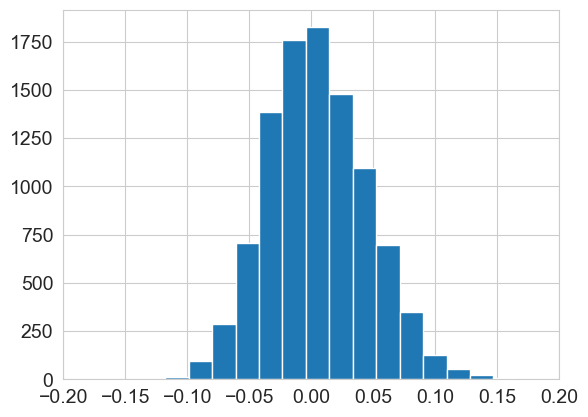

In [119]:
interference_values = []
for f in range(100):
    input = t.zeros(1, 1, 100, device=device)
    input[..., f] = 1
    interference_values.append(reluPlusX_res_embed_cis(input))

interference_values = t.stack(interference_values)
plt.hist(asnumpy(interference_values.ravel()), bins=100)
plt.xlim(-0.2, 0.2)

In [107]:
W1_hat = einsum(
    t.linalg.pinv(reluPlusX_res_embed_cis.We),
    reluPlusX_res_embed_cis.W1, 
    "i feat emb, i neuron emb -> i neuron feat"
)
W2_hat = einsum(
    t.linalg.pinv(reluPlusX_res_embed_cis.Wu),
    reluPlusX_res_embed_cis.W2, 
    "i emb feat, i emb neuron -> i feat neuron"
)

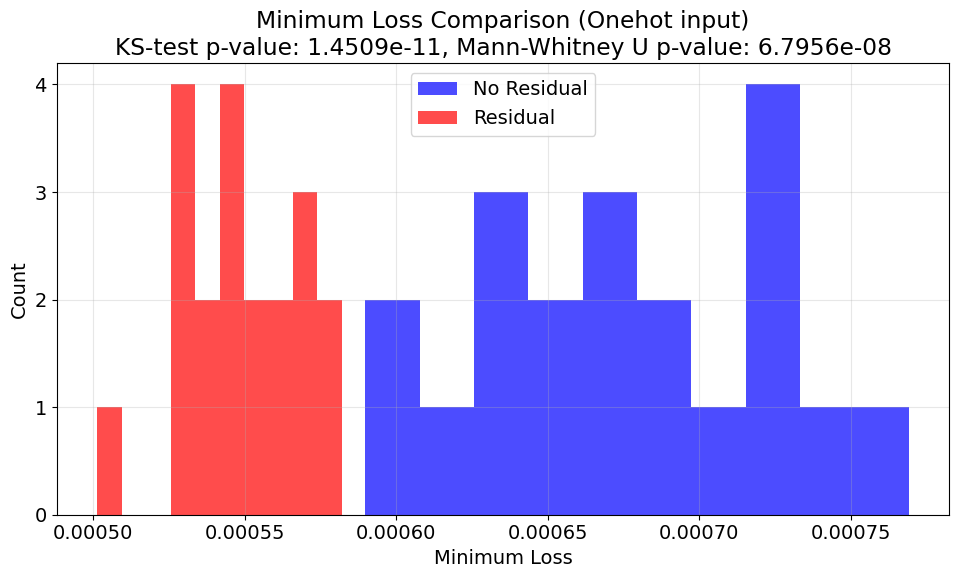

In [82]:
# Create a histogram comparing min_loss_res_onehot and min_loss_nores_onehot with statistical tests

# Perform statistical tests
ks_statistic, ks_pvalue = stats.kstest(min_loss_res_onehot, min_loss_nores_onehot)
mw_statistic, mw_pvalue = stats.mannwhitneyu(min_loss_res_onehot, min_loss_nores_onehot)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(min_loss_nores_onehot, alpha=0.7, label='No Residual', color='blue', bins=10)
plt.hist(min_loss_res_onehot, alpha=0.7, label='Residual', color='red', bins=10)

plt.title(f'Minimum Loss Comparison (Onehot input)\nKS-test p-value: {ks_pvalue:.4e}, Mann-Whitney U p-value: {mw_pvalue:.4e}')
plt.xlabel('Minimum Loss')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yticks(np.arange(0, 5, 1))
plt.show()

In [7]:
@t.no_grad()
def eval(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [10]:
n_runs = 20
min_loss_base = []
min_loss_pre = []
min_loss_post = []

pbar = tqdm(range(n_runs), desc="Training over runs")
for run in pbar:
    layer_act_fns = [t.relu, lambda x: x]

    # Train res model

    def gen_batch(
        model: Cis,
        batch_sz: int, 
        sparsity: float | Float[Tensor, "inst feat"],
        device: t.device
    ) -> (
        tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
    ):
        # """Generates a batch of x, y data."""
        # # Randomly generate features vals, and for each, randomly set which samples are non-zero
        # x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
        # is_active = (
        #     t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
        # )
        # x *= is_active
        # return x, t.relu(x) + x
        """Generates a batch of x, y data."""
        x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
        active_positions = t.randint(
                0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
        )
        active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
        
        # Create index tensors for vectorized assignment
        batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
        instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
        x[batch_idx, instance_idx, active_positions] = active_values
        
        return x, t.relu(x)

    relu_res_embed_cfg = CisConfig(
        n_instances=1,
        n_feat=100,
        n_hidden=50,
        act_fn=layer_act_fns,
        b1=None,
        b2=None,
        # skip_cnx=True,
        We_and_Wu=True,
        We_dim=1000
    )

    reluPlusX_res_embed_cis = Cis(relu_res_embed_cfg, device=device)

    batch_sz = 256
    feat_sparsity = 0.99
    feat_importance = 1
    n_steps = 5000
    logging_freq = n_steps // 10
    optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

    losses_base = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq,
        device
    )
    min_loss_base.append(min(losses_base))

    # Transplant weights from res model to no res model

    relu_embed_transplant_from_res_embed_cfg = CisConfig(
        n_instances=1,
        n_feat=100,
        n_hidden=50,
        act_fn=layer_act_fns,
        b1=None,
        b2=None,
        skip_cnx=True,
        We_and_Wu=True,
        We_dim=1000
    )

    relu_embed_transplant_from_res_embed_cis = Cis(relu_embed_transplant_from_res_embed_cfg, device=device)
    relu_embed_transplant_from_res_embed_cis.W1 = reluPlusX_res_embed_cis.W1
    relu_embed_transplant_from_res_embed_cis.W2 = reluPlusX_res_embed_cis.W2
    relu_embed_transplant_from_res_embed_cis.We = reluPlusX_res_embed_cis.We
    relu_embed_transplant_from_res_embed_cis.Wu = reluPlusX_res_embed_cis.Wu

    # Compute loss before fine-tuning no res model
    
    def gen_batch(
        model: Cis,
        batch_sz: int, 
        sparsity: float | Float[Tensor, "inst feat"],
        device: t.device
    ) -> (
        tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
    ):
        # """Generates a batch of x, y data."""
        # # Randomly generate features vals, and for each, randomly set which samples are non-zero
        # x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
        # is_active = (
        #     t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
        # )
        # x *= is_active
        # return x, t.relu(x)
        """Generates a batch of x, y data."""
        x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
        active_positions = t.randint(
                0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
        )
        active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
        
        # Create index tensors for vectorized assignment
        batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
        instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
        x[batch_idx, instance_idx, active_positions] = active_values
        
        return x, t.relu(x) + x


    losses_pre = eval(
        relu_embed_transplant_from_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        logging_freq,
        device
    )
    min_loss_pre.append(min(losses_pre))

    # Fine-tune no res model, and compute loss after

    optimizer = t.optim.Adam(relu_embed_transplant_from_res_embed_cis.parameters(), lr=5e-4)

    losses_post = train(
        relu_embed_transplant_from_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq,
        device
    )
    min_loss_post.append(min(losses_post))


Training over runs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
min_loss_post_res_into_nores = np.array(min_loss_post_res_into_nores)-0.00015

# min_loss_pre_res_into_nores = min_loss_pre
# min_loss_post_res_into_nores = min_loss_post

# min_loss_pre_nores_into_res = min_loss_pre
# min_loss_post_nores_into_res = min_loss_post

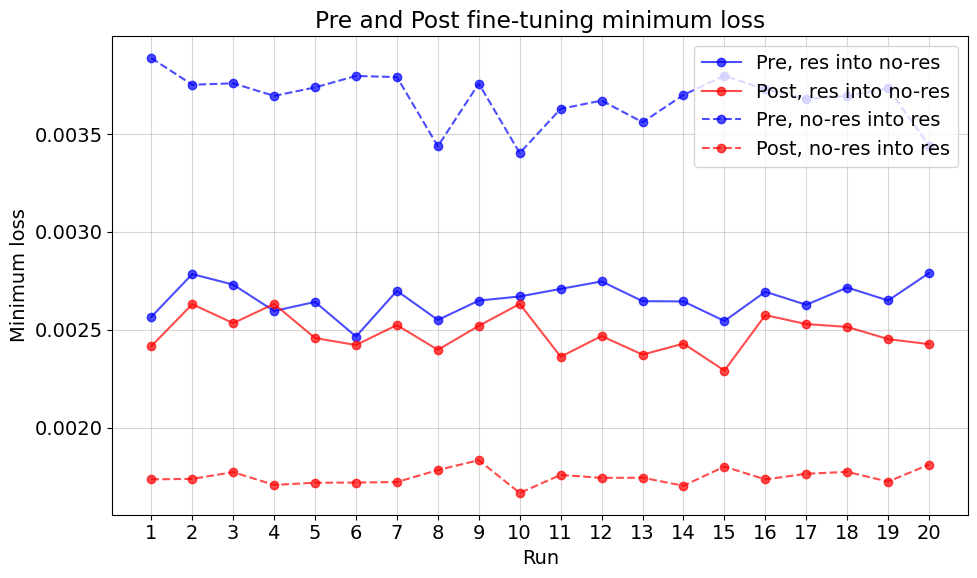

In [24]:
# Create a figure
plt.figure(figsize=(10, 6))

# ks_statistic, ks_pvalue = kstest(min_loss_pre, min_loss_post)
# mw_statistic, mw_pvalue = mannwhitneyu(min_loss_pre, min_loss_post, alternative='two-sided')

# Plot both lists against their indices
indices = np.arange(n_runs) + 1
plt.plot(indices, min_loss_pre_res_into_nores, 'b-o', label='Pre, res into no-res', alpha=0.7)
plt.plot(indices, min_loss_post_res_into_nores, 'r-o', label='Post, res into no-res', alpha=0.7)
plt.plot(indices, min_loss_pre_nores_into_res, 'b--o', label='Pre, no-res into res', alpha=0.7)
plt.plot(indices, min_loss_post_nores_into_res, 'r--o', label='Post, no-res into res', alpha=0.7)

# Add labels and title
plt.xlabel('Run')
plt.ylabel('Minimum loss')
# plt.title(f'Pre and Post Fine-tuning minimum loss\nKS-test p-value: {ks_pvalue:.4e}, Mann-Whitney U p-value: {mw_pvalue:.4e}')
plt.title(f'Pre and Post fine-tuning minimum loss')

# Add grid for better readability
plt.grid(alpha=0.5)

# Add legend
plt.legend()

# Ensure ticks are at integer positions for indices
plt.xticks(indices)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
title = "embed_transplant_from_res_embed (onehot inputs)"
title = "res_embed_transplant_from_embed (onehot inputs)"

### viz

#### input-output response

In [81]:
err.mean()

tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>)

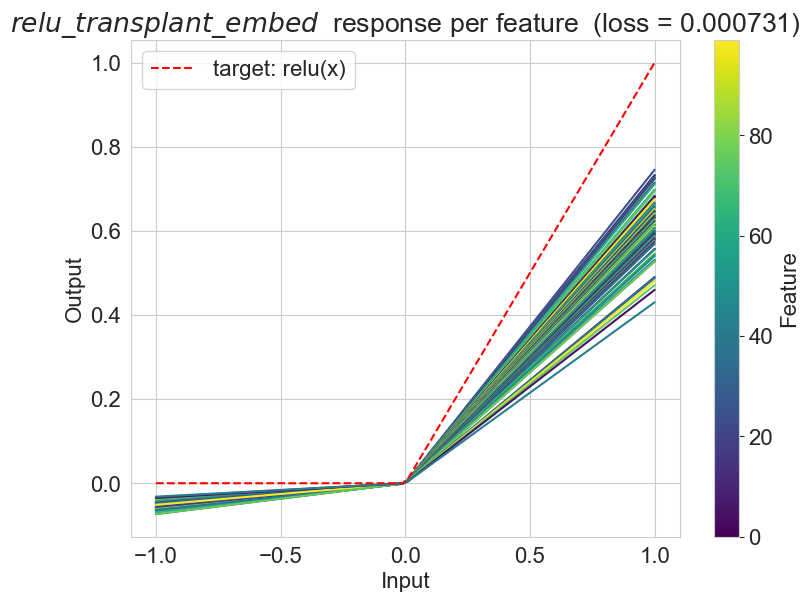

In [80]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_embed_transplant_from_res_embed_cis, vals, device)
# for feat in range(Y.shape[1]):
#     Y[:, feat] -= vals[feat]

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "mean")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)"
)
ax.set_title(
    r"$\mathit{relu\_transplant\_embed}$  "
    + f"response per feature  (loss = {losses[-1]:.6f})"
)
ax.legend()
ax.grid(True)
# ax.set_yticks(np.arange(-1.25, 2.25, 0.25))

#### weights

In [11]:
reluPlusX_res_embed_cis.We.shape, reluPlusX_res_embed_cis.W1.shape, reluPlusX_res_embed_cis.W2.shape, reluPlusX_res_embed_cis.Wu.shape

(torch.Size([1, 1000, 100]),
 torch.Size([1, 50, 1000]),
 torch.Size([1, 1000, 50]),
 torch.Size([1, 100, 1000]))

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{reluPlusX\\_res\\_embed}$  feature weights per neuron')

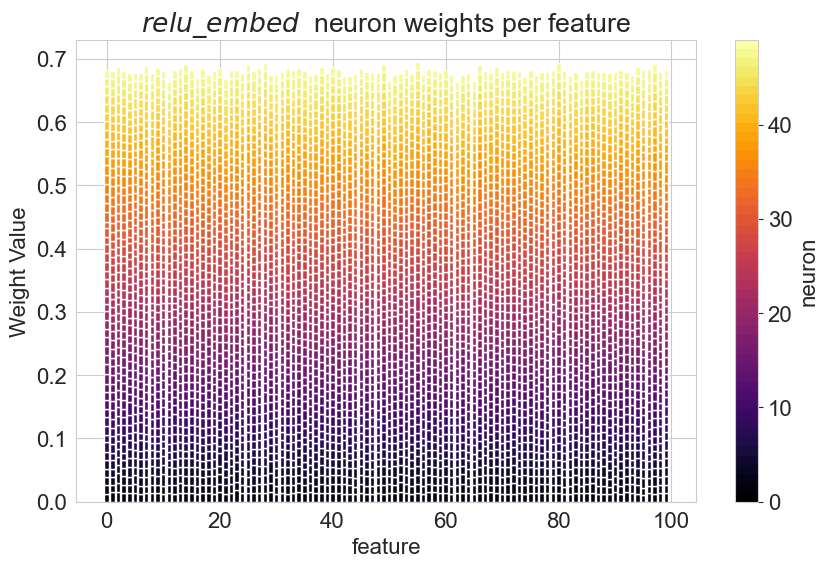

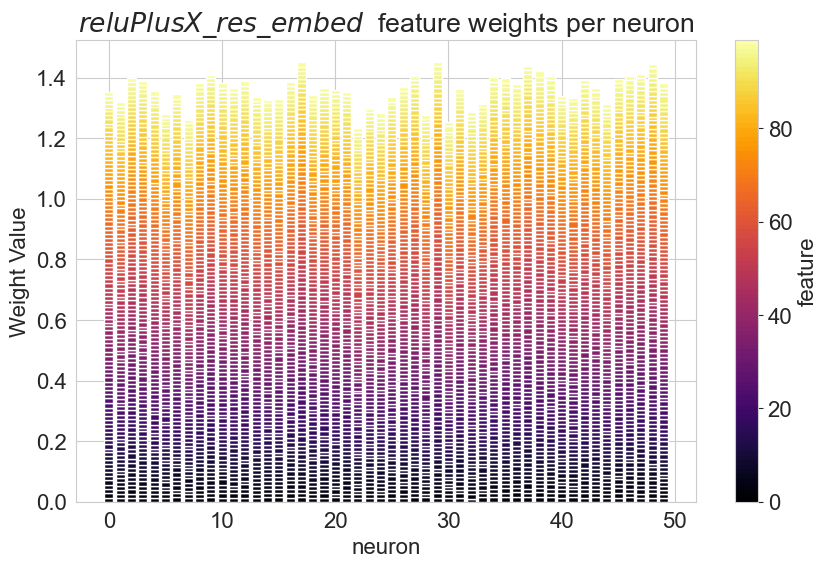

In [44]:
"""Plot weights for neurons per feature, and for features per neuron."""

# W = einsum(reluPlusX_res_embed_cis.W1, reluPlusX_res_embed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = einsum(
    relu_embed_transplant_from_res_embed_cis.We,
    relu_embed_transplant_from_res_embed_cis.W1,
    relu_embed_transplant_from_res_embed_cis.W2,
    relu_embed_transplant_from_res_embed_cis.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
# W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title(r"$\mathit{relu\_embed}$  neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_embed}$  feature weights per neuron")

#### loss and polysemanticity as a function of sparsity

In [6]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device).to(device)
    optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters())
    losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        reluPlusX_res_embed_cis.W1,
        reluPlusX_res_embed_cis.W2,
        "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / reluPlusX_res_embed_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(reluPlusX_res_embed_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, reluPlusX_res_embed_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(reluPlusX_res_embed_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                reluPlusX_res_embed_cis.cfg.n_instances, 
                reluPlusX_res_embed_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = reluPlusX_res_embed_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

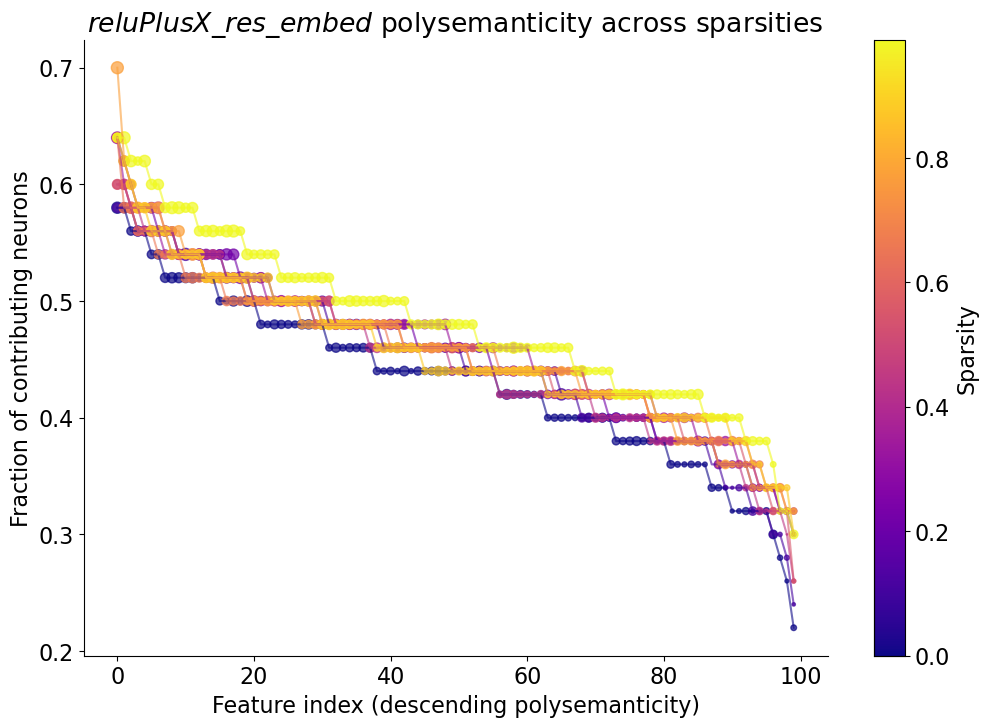

In [7]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{reluPlusX\_res\_embed}$ polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

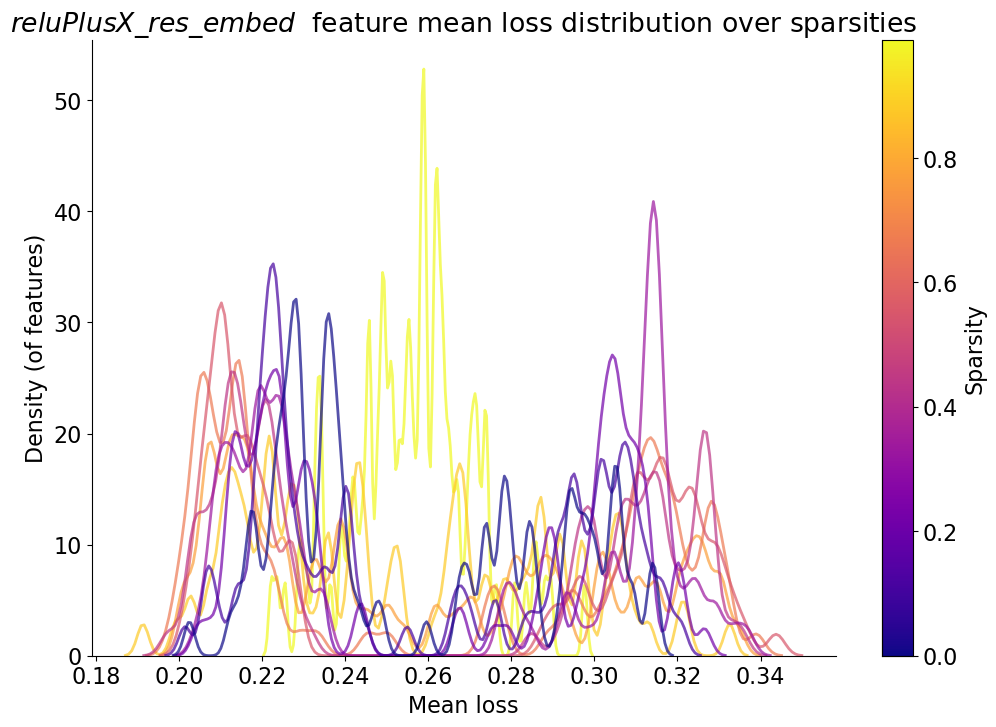

In [9]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{reluPlusX\_res\_embed}$  feature mean loss distribution over sparsities")
# ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

## *abs*

. . .

### training

In [5]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.abs(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [ ]:
"""Create and train model."""

layer_act_fns = [t.relu, t.relu]

abs_cfg = CisConfig(
    n_instances=1,
    n_feat=50,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=0.0,
    skip_cnx=False,
    We_and_Wu=False,
)

abs_cis = Cis(abs_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(abs_cis.parameters(), lr=5e-4)

losses = train(
    abs_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

## transplanting weights from *onehot_weightedMse*

### pre-translplanted input-output response and loss over feature_prob

In [35]:
"""Define training functions."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [108]:
"""Create model."""

layer_act_fns = [t.relu, lambda x: x]

relu_cis_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
)

relu_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)

In [63]:
"""Train model."""

batch_sz = 1024
feat_sparsity = 0.99
feat_importance = 1
n_steps = 5000
logging_freq = n_steps // 100
optimizer = t.optim.Adam(relu_cis.parameters(), lr=5e-4)

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq,
    device
)
display(losses)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0017794196028262377,
 0.0015956914285197854,
 0.0014126681489869952,
 0.0015299043152481318,
 0.0011880261590704322,
 0.0011417340720072389,
 0.0008955087978392839,
 0.0009169818367809057,
 0.0009507533977739513,
 0.0009664112003520131,
 0.0009228958515450358,
 0.0009492982644587755,
 0.0008952144999057055,
 0.0009108718950301409,
 0.0009678478236310184,
 0.0008858258952386677,
 0.0008462870609946549,
 0.0009823233122006059,
 0.0010068181436508894,
 0.0009745670831762254,
 0.000920542748644948,
 0.0008655863930471241,
 0.0008559219422750175,
 0.0009221871150657535,
 0.0009589972905814648,
 0.0009219695348292589,
 0.0009120586910285056,
 0.0007577126962132752,
 0.0010095473844558,
 0.0008688654052093625,
 0.0008660214953124523,
 0.0009499349980615079,
 0.0009409476770088077,
 0.0009649822022765875,
 0.0009180810302495956,
 0.0009658911731094122,
 0.000970788358245045,
 0.0009053894900716841,
 0.0009278692887164652,
 0.0008283290080726147,
 0.0009328511077910662,
 0.000917574565391987

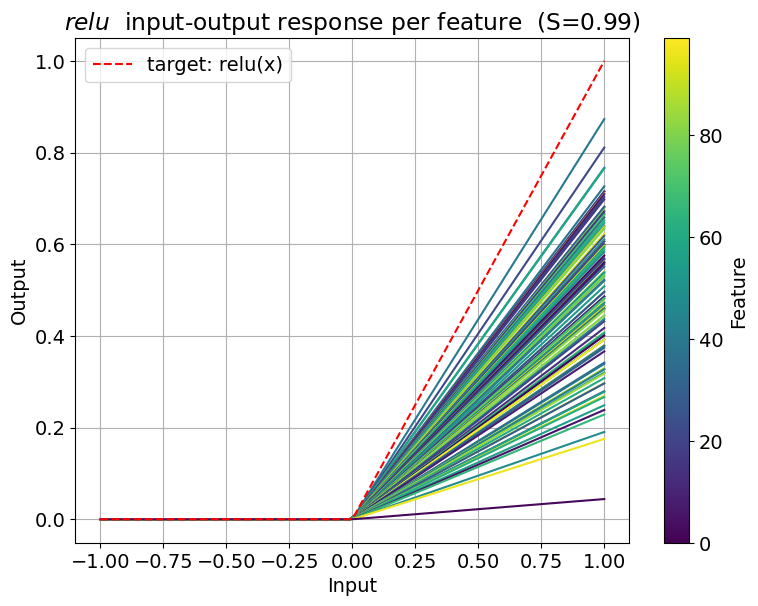

In [65]:
"""Plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals) + vals, "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(
    r"$\mathit{relu}$  " 
    + f"input-output response per feature  (S={feat_sparsity})"
)
ax.legend()
ax.grid(True)

In [51]:
"""Plot loss over feature_prob."""

sparsities = [0.9, 0.95, 0.98, 0.99]

loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_cis = Cis(relu_cis_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_cis.parameters())
    losses = train(
        relu_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq,
        device
    )
    loss_data.append(np.min(losses))

Training over sparsities:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

In [52]:
loss_data

[np.float64(0.007549335714429617),
 np.float64(0.0038997232913970947),
 np.float64(0.0015598329482600093),
 np.float64(0.0007708519697189331)]

### post-translplanted input-output response and loss over feature_prob

In [53]:
relu_wmse_onehot_weights = t.load("../data/weighted_mse_onehot.pt")
relu_wmse_onehot_weights["W1"] = rearrange(relu_wmse_onehot_weights["W1"], "inst a b -> inst b a")
relu_wmse_onehot_weights["W2"] = rearrange(relu_wmse_onehot_weights["W2"], "inst b a -> inst a b")
relu_cis.load_state_dict(relu_wmse_onehot_weights)

C:\Users\jai\AppData\Local\Temp\ipykernel_37388\1241464963.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  relu_wmse_onehot_weights = t.load("../data/weighted_mse_onehot

<All keys matched successfully>

In [109]:
relu_cis.W1 = nn.Parameter(W1_hat)
relu_cis.W2 = nn.Parameter(W2_hat)

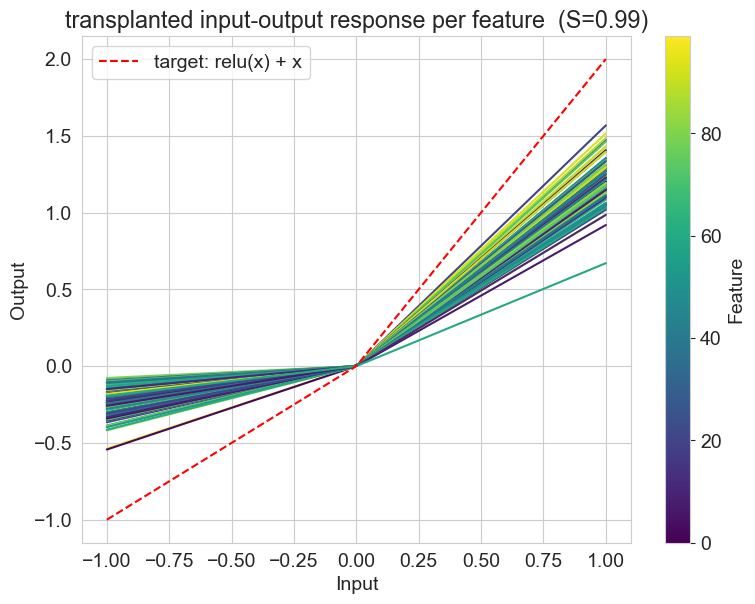

In [110]:
vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals) + vals, "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals) + vals), color="red", linestyle="--", label="target: relu(x) + x")
ax.set_title(f"transplanted input-output response per feature  (S={feat_sparsity})")
ax.legend()
ax.grid(True)

In [55]:
sparsities = [0.9, 0.95, 0.98, 0.99]

loss_data_transplant = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_cis = Cis(relu_cis_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_cis.parameters())
    losses = eval(
        relu_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        n_steps,
        logging_freq,
        device
    )
    loss_data_transplant.append(np.min(losses))

Training over sparsities:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

In [56]:
loss_data_transplant

[np.float64(0.016082128509879112),
 np.float64(0.007739229127764702),
 np.float64(0.0029783861245959997),
 np.float64(0.0014744035433977842)]

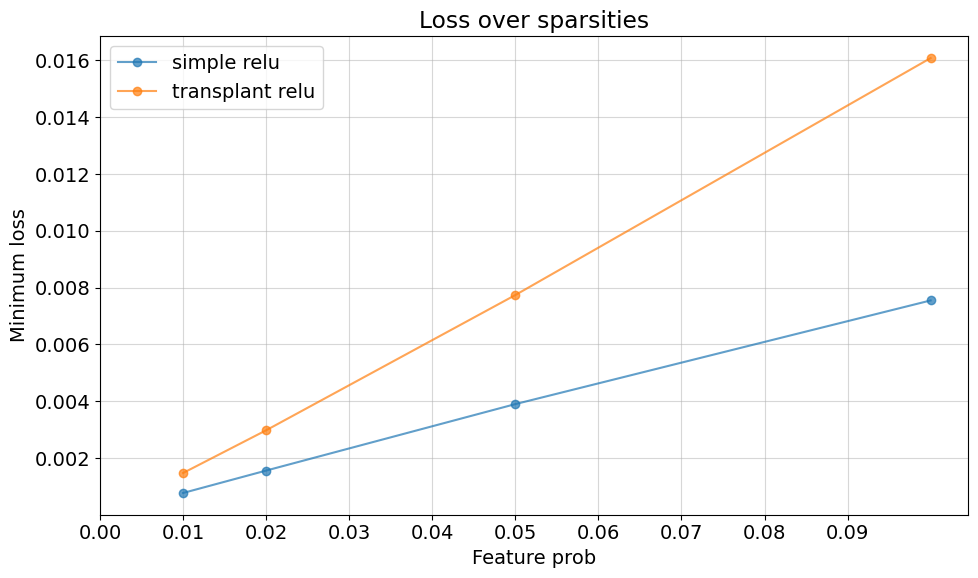

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(1 - np.array(sparsities), loss_data, label='simple relu', alpha=0.7, marker='o')
plt.plot(1 - np.array(sparsities), loss_data_transplant, label='transplant relu', alpha=0.7, marker='o')

plt.xticks(np.arange(0,0.1,0.01))
plt.xlabel("Feature prob")
plt.ylabel("Minimum loss")
plt.title("Loss over sparsities")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

## figuring out unequal feature representation but equal adjusted weights plots

In [9]:
def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x) + x

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [11]:
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters())

batch_sz = 1024
feat_sparsity = 0.50
feat_importance = 1
lr = 3e-3
n_steps = 5000
logging_freq = n_steps // 10


losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq,
        device
)
display(losses)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.09982927143573761,
 0.03903611749410629,
 0.03643475100398064,
 0.03640118986368179,
 0.03650515526533127,
 0.0365426279604435,
 0.03639335185289383,
 0.03613726422190666,
 0.03649285435676575,
 0.03653625771403313,
 0.035623904317617416]

In [15]:
sorted_feat_idxs

[16,
 95,
 22,
 4,
 3,
 97,
 87,
 74,
 21,
 27,
 61,
 0,
 23,
 64,
 17,
 6,
 89,
 36,
 8,
 34,
 10,
 46,
 82,
 13,
 69,
 18,
 88,
 29,
 76,
 98,
 37,
 14,
 12,
 68,
 57,
 83,
 30,
 60,
 58,
 90,
 81,
 53,
 42,
 54,
 79,
 93,
 15,
 55,
 94,
 39,
 2,
 67,
 51,
 31,
 80,
 77,
 19,
 20,
 49,
 40,
 9,
 45,
 47,
 41,
 85,
 33,
 86,
 73,
 71,
 5,
 38,
 44,
 92,
 24,
 35,
 11,
 66,
 96,
 62,
 84,
 75,
 59,
 99,
 65,
 78,
 25,
 70,
 28,
 32,
 52,
 1,
 50,
 7,
 56,
 43,
 91,
 63,
 72,
 48,
 26]

In [20]:
vals

tensor([-1.0000, -0.9798, -0.9596, -0.9394, -0.9192, -0.8990, -0.8788, -0.8586,
        -0.8384, -0.8182, -0.7980, -0.7778, -0.7576, -0.7374, -0.7172, -0.6970,
        -0.6768, -0.6566, -0.6364, -0.6162, -0.5960, -0.5758, -0.5556, -0.5354,
        -0.5152, -0.4949, -0.4747, -0.4545, -0.4343, -0.4141, -0.3939, -0.3737,
        -0.3535, -0.3333, -0.3131, -0.2929, -0.2727, -0.2525, -0.2323, -0.2121,
        -0.1919, -0.1717, -0.1515, -0.1313, -0.1111, -0.0909, -0.0707, -0.0505,
        -0.0303, -0.0101,  0.0101,  0.0303,  0.0505,  0.0707,  0.0909,  0.1111,
         0.1313,  0.1515,  0.1717,  0.1919,  0.2121,  0.2323,  0.2525,  0.2727,
         0.2929,  0.3131,  0.3333,  0.3535,  0.3737,  0.3939,  0.4141,  0.4343,
         0.4545,  0.4747,  0.4949,  0.5152,  0.5354,  0.5556,  0.5758,  0.5960,
         0.6162,  0.6364,  0.6566,  0.6768,  0.6970,  0.7172,  0.7374,  0.7576,
         0.7778,  0.7980,  0.8182,  0.8384,  0.8586,  0.8788,  0.8990,  0.9192,
         0.9394,  0.9596,  0.9798,  1.00

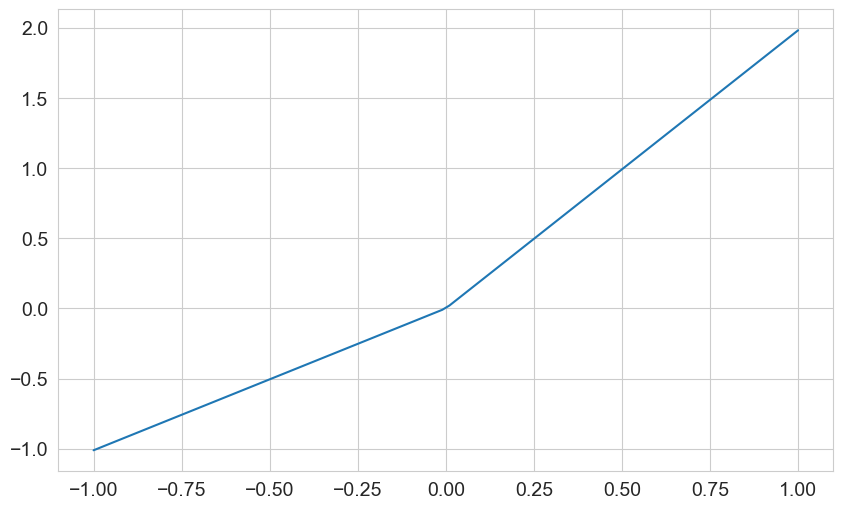

In [113]:
feat_idx = sorted_feat_idxs[-1]
inp = t.zeros(100, 1, 100, device=device)
inp[..., feat_idx] = rearrange(vals, "val -> val 1")

y_hat = reluPlusX_res_embed_cis(inp)
y_hat = y_hat[..., feat_idx].squeeze()

# Plot vals vs y_hat
plt.figure(figsize=(10, 6))
plt.plot(asnumpy(vals), asnumpy(y_hat))

In [ ]:
# emb_X = reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat

In [114]:
We = reluPlusX_res_embed_cis.We[..., feat_idx].squeeze()
W1 = reluPlusX_res_embed_cis.W1.squeeze()
W2 = reluPlusX_res_embed_cis.W2.squeeze()
Wu = reluPlusX_res_embed_cis.Wu.squeeze()

print(f"We shape: {We.shape}")
print(f"W1 shape: {W1.shape}")
print(f"W2 shape: {W2.shape}")
print(f"Wu shape: {Wu.shape}")

We shape: torch.Size([1000])
W1 shape: torch.Size([50, 1000])
W2 shape: torch.Size([1000, 50])
Wu shape: torch.Size([100, 1000])


In [117]:
inp = t.zeros(1, 1, 100, device=device)
inp[..., feat_idx] = 1
reluPlusX_res_embed_cis(inp)

> d:\google_drive\pkb\x\machine_learning\deep_learning\mechanistic_interpretability\toy-model-of-computation-in-superposition\toy_cis\models.py(114)forward()
    113         # Embedding layer
--> 114         if self.cfg.We_and_Wu:
    115             x = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")

> d:\google_drive\pkb\x\machine_learning\deep_learning\mechanistic_interpretability\toy-model-of-computation-in-superposition\toy_cis\models.py(115)forward()
    114         if self.cfg.We_and_Wu:
--> 115             x = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
    116 

> d:\google_drive\pkb\x\machine_learning\deep_learning\mechanistic_interpretability\toy-model-of-computation-in-superposition\toy_cis\models.py(118)forward()
    117         # Hidden layer
--> 118         h = einsum(x, self.W1, "batch inst feat, inst hid feat -> batch inst hid")
    119         h = self.cfg.act_fn[0](h + self.b1)

torch.Size([1, 1, 1000])
*** NameError

In [ ]:
We.sum()

tensor(1.4166, device='cuda:0')

In [101]:
We_m = einsum(inp, reluPlusX_res_embed_cis.We, "batch inst feat, inst emb feat -> batch inst emb")
We_m.sum()

tensor(1.4166, device='cuda:0')

In [103]:
h = t.relu(W1 @ We)
h

tensor([1.1228e-03, 3.1378e-02, 0.0000e+00, 0.0000e+00, 3.7688e-02, 0.0000e+00,
        0.0000e+00, 2.2773e-02, 1.6919e-02, 1.5382e-02, 0.0000e+00, 8.9503e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0140e-02, 0.0000e+00, 0.0000e+00,
        2.1458e-02, 0.0000e+00, 3.4121e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.9689e-02, 1.7461e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.1424e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0221e-02, 8.7298e-01,
        1.8315e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7503e-03, 0.0000e+00,
        0.0000e+00, 1.9074e-03, 4.4488e-03, 0.0000e+00, 1.2090e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0', grad_fn=<ReluBackward0>)

In [106]:
h_m = t.relu(einsum(
    We_m, reluPlusX_res_embed_cis.W1, "batch inst feat, inst hid feat -> batch inst hid")
)
h_m

tensor([[[1.1228e-03, 3.1378e-02, 0.0000e+00, 0.0000e+00, 3.7688e-02,
          0.0000e+00, 0.0000e+00, 2.2773e-02, 1.6919e-02, 1.5382e-02,
          0.0000e+00, 8.9503e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0140e-02, 0.0000e+00, 0.0000e+00, 2.1458e-02, 0.0000e+00,
          3.4121e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9689e-02,
          1.7461e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          6.1424e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0221e-02,
          8.7298e-01, 1.8315e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          5.7503e-03, 0.0000e+00, 0.0000e+00, 1.9074e-03, 4.4488e-03,
          0.0000e+00, 1.2090e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00]]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [108]:
y = W2 @ h
y

tensor([ 9.6917e-02,  6.2466e-02, -1.5619e-02,  2.1765e-02, -2.5595e-02,
         2.4764e-02,  1.3404e-04, -6.0097e-02, -8.3066e-04,  1.4524e-03,
        -2.6407e-02, -2.2186e-02,  1.9801e-02,  1.4409e-03, -2.4524e-02,
         8.3042e-03,  2.5048e-02,  3.1197e-02,  2.3157e-02,  1.2707e-01,
        -1.6006e-02,  5.5024e-02,  7.5151e-02,  7.8983e-02,  8.5398e-03,
        -4.7066e-02,  1.8301e-02,  6.6769e-02, -2.1614e-02, -6.7700e-03,
         5.1861e-02, -7.5748e-03, -2.0261e-02,  2.3740e-03,  3.0860e-02,
         1.2663e-02,  7.6361e-02, -4.3972e-02,  7.2236e-02,  3.2540e-02,
         3.3598e-04, -5.6901e-03, -5.0054e-02,  1.8630e-02,  8.7590e-02,
         4.1212e-02, -6.7283e-02, -4.6880e-02,  3.3370e-03,  5.5259e-02,
        -2.6011e-02,  4.6771e-02, -4.8698e-02, -7.3110e-02,  6.9486e-02,
        -9.8052e-03,  3.9090e-02, -5.6692e-02,  7.8374e-02, -1.1381e-02,
         6.6218e-02,  3.5956e-02,  3.3336e-02,  6.0971e-02,  6.2987e-02,
        -2.1023e-02, -3.7537e-02,  1.7233e-02, -6.0

In [110]:
y_m = einsum(
    h_m, reluPlusX_res_embed_cis.W2, "batch inst hid, inst feat hid -> batch inst feat"
)
y_m

tensor([[[ 9.6917e-02,  6.2466e-02, -1.5619e-02,  2.1765e-02, -2.5595e-02,
           2.4764e-02,  1.3404e-04, -6.0097e-02, -8.3066e-04,  1.4524e-03,
          -2.6407e-02, -2.2186e-02,  1.9801e-02,  1.4409e-03, -2.4524e-02,
           8.3042e-03,  2.5048e-02,  3.1197e-02,  2.3157e-02,  1.2707e-01,
          -1.6006e-02,  5.5024e-02,  7.5151e-02,  7.8983e-02,  8.5398e-03,
          -4.7066e-02,  1.8301e-02,  6.6769e-02, -2.1614e-02, -6.7700e-03,
           5.1861e-02, -7.5748e-03, -2.0261e-02,  2.3740e-03,  3.0860e-02,
           1.2663e-02,  7.6361e-02, -4.3972e-02,  7.2236e-02,  3.2540e-02,
           3.3598e-04, -5.6901e-03, -5.0054e-02,  1.8630e-02,  8.7590e-02,
           4.1212e-02, -6.7283e-02, -4.6880e-02,  3.3370e-03,  5.5259e-02,
          -2.6011e-02,  4.6771e-02, -4.8698e-02, -7.3110e-02,  6.9486e-02,
          -9.8052e-03,  3.9090e-02, -5.6692e-02,  7.8374e-02, -1.1381e-02,
           6.6218e-02,  3.5956e-02,  3.3336e-02,  6.0971e-02,  6.2987e-02,
          -2.1023e-02, -3

---

---

In [116]:
(W2 @ t.relu(W1 @ We)).shape

torch.Size([1000])

In [ ]:
# (Wu @ (inp + (W2 @ t.relu(W1 @ We)))).sum()

RuntimeError: The size of tensor a (100) must match the size of tensor b (1000) at non-singleton dimension 2

In [86]:
einsum(t.relu(W1 @ We), W2, Wu, "neuron, emb neuron, feat emb -> ")

tensor(1.7203, device='cuda:0', grad_fn=<ViewBackward0>)

In [55]:
einsum(Wu, W2, W1, We, "feat emb, emb neuron, neuron emb, emb -> feat")

tensor([ 9.1657e-04,  6.1230e-04, -6.4760e-03, -5.7262e-04, -1.9092e-04,
         1.8940e-03,  1.3448e-03, -3.6492e-03,  1.5344e-03,  3.2817e-03,
         2.4930e-03,  4.5682e-03,  4.6365e-03, -1.5687e-03,  1.0332e-03,
        -4.5929e-03, -1.9652e-04,  2.3194e-03,  4.4313e-04, -3.1985e-03,
        -1.6742e-03,  3.8336e-03,  1.5324e-03,  3.8912e-04, -1.1318e-03,
         2.1345e-03,  9.2330e-02,  4.6888e-04,  5.7936e-03, -2.5769e-03,
         3.6205e-03,  1.3138e-03, -7.7284e-04, -3.0812e-03, -5.7992e-03,
         2.3342e-03, -5.8206e-03, -7.0192e-04,  1.5570e-04,  9.8651e-03,
        -8.5749e-04,  5.9979e-04,  4.7565e-03, -5.0472e-04,  2.6141e-03,
        -6.6371e-04, -6.2520e-03, -4.5655e-03,  2.3817e-03, -5.1006e-03,
         5.0122e-03, -6.1600e-03,  1.8155e-03,  8.3723e-05,  1.9498e-03,
        -8.4180e-04, -4.8474e-04, -2.1960e-03, -5.4125e-04, -4.3803e-03,
         3.2974e-03, -4.0477e-03, -1.0398e-03,  1.1463e-03,  4.5527e-05,
        -2.0465e-03,  1.2433e-03,  1.2055e-03,  5.0

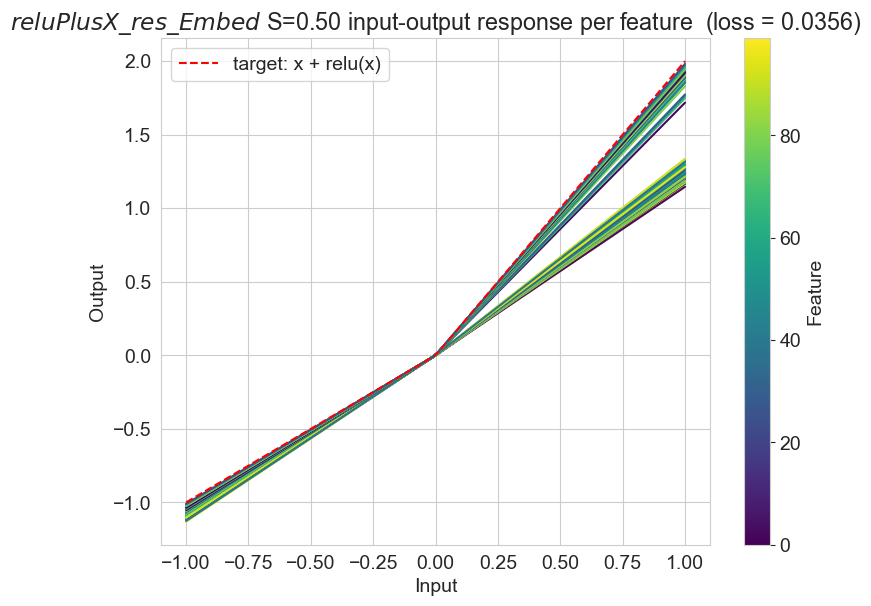

In [27]:
"""Plot feature representation (input-output response)"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_Embed}$ S=0.50 " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()
ax.grid(True)

We.shape= torch.Size([1, 1000, 100])
W1.shape= torch.Size([1, 50, 1000])
W2.shape= torch.Size([1, 1000, 50])
Wu.shape= torch.Size([1, 100, 1000])
W.shape=torch.Size([50, 100])


Text(0.5, 1.0, 'ReLU_PlusX_NoEmbed S = 0.50 feature weights per neuron')

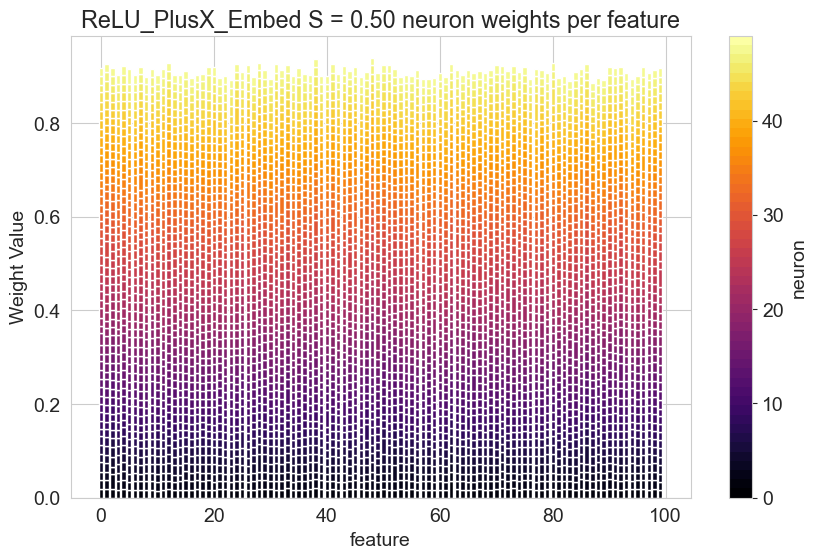

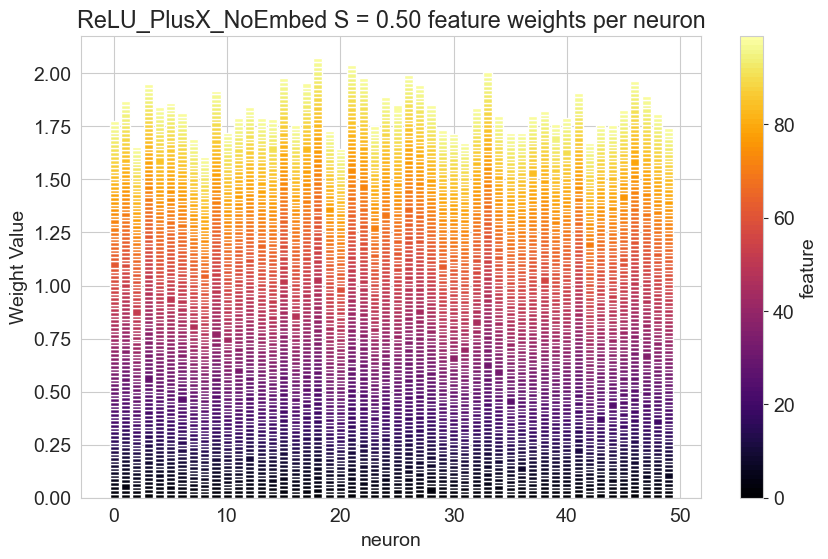

In [34]:
"""Plot weights for neurons per feature, and for features per neuron."""
W = einsum(
    reluPlusX_res_embed_cis.We,
    reluPlusX_res_embed_cis.W1,
    reluPlusX_res_embed_cis.W2,
    reluPlusX_res_embed_cis.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
# W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"We.shape= {reluPlusX_res_embed_cis.We.shape}")
print(f"W1.shape= {reluPlusX_res_embed_cis.W1.shape}")
print(f"W2.shape= {reluPlusX_res_embed_cis.W2.shape}")
print(f"Wu.shape= {reluPlusX_res_embed_cis.Wu.shape}")
print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.50 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.50 feature weights per neuron")